In [13]:
# read in libraries, including
# AWS python library, boto3
%matplotlib inline 
# moved up
import boto3
from boto3.dynamodb.conditions import Key, Attr
# pandas, for data analysis
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
#plotting 
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
plt.style.use('ggplot')
import scipy.stats

# Get the service resource.
dynamodb = boto3.resource('dynamodb')
table = dynamodb.Table('BaltimoreOpenAir2017')

def easy_scatter(x,y,title='', xlabel='', ylabel='') : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    #r = np.corrcoef(x[ind], y[ind])[0,1]
    r,p = scipy.stats.pearsonr(x[ind], y[ind])
    plt.scatter(x,y)
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r= %.2f'%r, xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p= %.2f'%p, xy=(.5, .7), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

In [2]:
plt.rcParams.update({'font.size': 20})
plt.style.use('ggplot')

In [3]:
# read in metadata
meta = pd.read_csv('data/BaltimoreOpenAir2017_results.csv').set_index('id')

In [4]:
# read in the MDE data 
#### import MDE data 
#### note that this is not callibrated!!
mde = pd.read_csv('data/HU_minutedata.csv', header = 2,
                   #nrows = 10,
                   skipfooter=10,
                   parse_dates={'datetime': ['Date', 'Time']},
                   ).drop(0)
for col in [u'O3', u'SO2t(trace)', u'RH', u'Temp_10m', u'NO2(NOx)']: 
    mde[col] = pd.to_numeric(mde[col], errors = 'coerce')
    mde[col] = mde[col].dropna()
mde.index = [pd.datetime.strptime(x, '%m/%d/%Y %I:%M %p') for x in mde['datetime'].values]
mde.head()

/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.


,datetime,O3,SO2t(trace),RH,Temp_10m,NO2(NOx)
2017-09-07 00:00:00,9/7/2017 12:00 AM,10.0,0.0,93.0,57.0,5.6
2017-09-07 00:01:00,9/7/2017 12:01 AM,12.0,0.0,93.0,57.0,5.7
2017-09-07 00:02:00,9/7/2017 12:02 AM,13.0,0.0,93.0,57.0,5.8
2017-09-07 00:03:00,9/7/2017 12:03 AM,11.0,0.0,93.0,57.0,5.9
2017-09-07 00:04:00,9/7/2017 12:04 AM,10.0,0.0,93.0,57.0,5.9


In [108]:
meta.loc[10]

meta:instanceID               uuid:30a35dac-049b-465e-bb1b-903ae5355d95
qr_ozone                             050217012431 110401 O3 1705 -13.64
qr_no2                              071717010125 110501 NO2 1707 -31.76
qr_h2s                              071817010233 110303 H2S 1707 297.72
qr_so2                               071217010244 110601 SO2 1707 41.00
Location:Latitude                                               39.1599
Location:Longitude                                             -76.8214
Location:Altitude                                                     0
Location:Accuracy                                                  1400
sunorshade                                                          sun
photo                 https://bmorecoolodk.appspot.com/view/binaryDa...
install_time                               Thu Sep 07 14:26:41 UTC 2017
notes                                                    Mde beltsville
Name: 10, dtype: object

In [5]:
ids = (10,11,12,13,14)
o3df = pd.DataFrame()
so2df = pd.DataFrame()
h2sdf = pd.DataFrame()
no2df = pd.DataFrame()

o3stddf = pd.DataFrame()
for sel_id in ids : 
    #sel_id = 10
    m_o3 = float(meta.loc[sel_id]['qr_ozone'][28:])
    m_no2 = float(meta.loc[sel_id]['qr_no2'][28:])
    m_h2s = float(meta.loc[sel_id]['qr_h2s'][28:])
    m_so2= float(meta.loc[sel_id]['qr_so2'][28:])

    response = table.query(
                KeyConditionExpression=Key('id').eq(str(sel_id)) & Key('timest').gt(20170908000015)
            )
    df = pd.DataFrame(response['Items'])
    ## convert post timestamp to datetime
    df['timest'] = [pd.to_datetime(str(date)[:-4], format = '%Y%m%d%H%M') for date in df['timest']]
    # read in batteryAV to get the time
    df[['something', 'HourMinute', 'MonthDay', 'AV', 'drop'] ] = df['battAV'].str.split(',').apply(pd.Series)

    df[['O3_avg', 'O3_std']]   = df[['O3_avg', 'O3_std']].astype(float).multiply(0.01)#* m_o3)
    df[['NO2_avg', 'NO2_std']] = df[['NO2_avg', 'NO2_std']].astype(float).multiply(0.01)#*m_no2)
    df[['SO2_avg', 'SO2_std']] = df[['SO2_avg', 'SO2_std']].astype(float).multiply(0.01)#* m_so2)
    df[['H2S_avg', 'H2S_std']] = df[['H2S_avg', 'H2S_std']].astype(float).multiply(0.01)#* m_h2s)

    # set up time index 
    date_index = []
    for date in df[['MonthDay', 'HourMinute']].values : 
        try: 
            if date[0] == '32767' : 
                date_index.append(np.nan)
            elif date[0] == '0' : 
                date_index.append(np.nan)
            else:
                date_index.append(pd.to_datetime('2017' +date[0]+date[1], format = '%Y%m%d%H%M'))
        except ValueError:  
            date_index.append(np.nan)

    df['date_index'] = date_index
    df.index = pd.DatetimeIndex(date_index, freq = '15Min')
    df = df.loc['2017-09-07':]
    #o3df = o3df.append(df['O3_avg'].rename(columns={"O3_avg": sel_id}))
    o3df[sel_id] = df['O3_avg'].resample('15Min').mean().rename(columns={"O3_avg": sel_id})
    o3stddf[sel_id] = df['O3_std'].resample('15Min').mean().rename(columns={"O3_std": sel_id})
    
    so2df[sel_id] = df['SO2_avg'].resample('15Min').mean().rename(columns={"SO2_avg": sel_id})
    h2sdf[sel_id] = df['H2S_avg'].resample('15Min').mean().rename(columns={"H2S_avg": sel_id})
    no2df[sel_id] = df['NO2_avg'].resample('15Min').mean().rename(columns={"NO2_avg": sel_id})


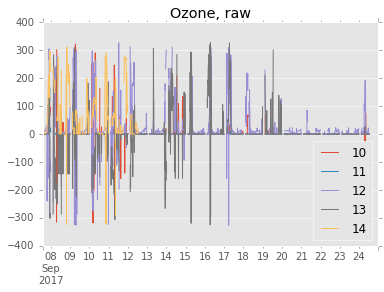

In [134]:
# plots of raw data, mde data 
o3df.plot(title = 'Ozone, raw')

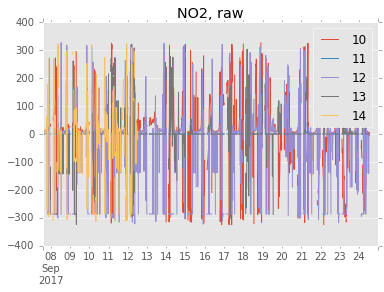

In [135]:
no2df.plot(title = 'NO2, raw')

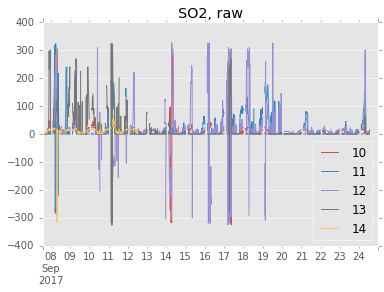

In [136]:
so2df.plot(title = 'SO2, raw')

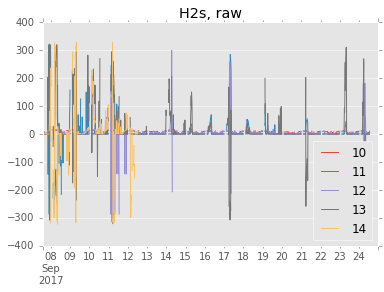

In [137]:
h2sdf.plot(title = 'H2s, raw')

In [68]:
# try modelling averaging all of the sensors
regdf = pd.DataFrame()
regdf['o3'] = o3df['2017-09-16'].mean(axis = 1)
regdf['no2'] = no2df['2017-09-16'].mean(axis = 1)
regdf['so2'] = so2df['2017-09-16'].mean(axis = 1)
regdf['h2s'] = h2sdf['2017-09-16'].mean(axis = 1)
regdf['tru_o3'] = mde['O3']['2017-09-16']
regdf['rh'] = mde['RH']['2017-09-16']
deltaRH = (mde['RH']['2017-09-16'].iloc[1:].values - mde['RH']['2017-09-16'].iloc[:-1].values)
regdf['drh'] = pd.Series(deltaRH, index = mde['2017-09-16'].iloc[:-1].index)

result = sm.ols(formula="o3 ~ tru_o3 + no2 + so2 + h2s", data=regdf).fit()
print(result.params)
print(result.summary())

Intercept   -0.558408
tru_o3      -0.070897
no2          0.036034
so2          0.187409
h2s          3.620994
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                     o3   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     19.62
Date:                Sun, 24 Sep 2017   Prob (F-statistic):           3.04e-11
Time:                        23:58:39   Log-Likelihood:                -398.45
No. Observations:                  84   AIC:                             806.9
Df Residuals:                      79   BIC:                             819.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------

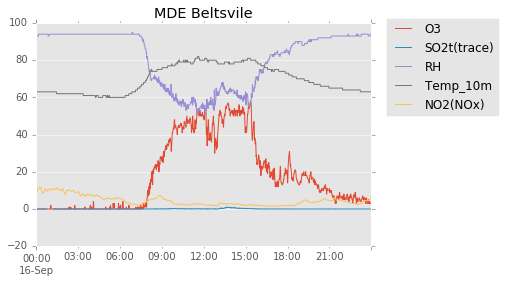

In [66]:
mde['2017-09-16'].plot()
plt.legend(bbox_to_anchor=(1.4, 1.05))
plt.title('MDE Beltsvile')

(0.78872624825174853, 0.81723437587210002, 7.1554702843139498e-20)

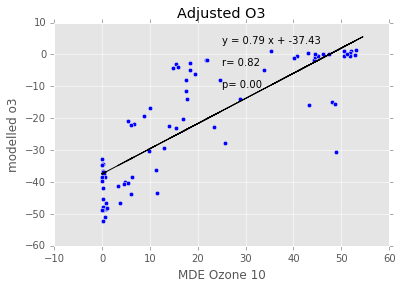

In [25]:
mod =  result.params['tru_o3']*mde['O3']['2017-09-16'] + result.params['so2']*so2df[col]['2017-09-16']+  result.params['h2s']*h2sdf[col]['2017-09-16']+  result.params['no2']*no2df[col]['2017-09-16'] 
easy_scatter(mde['O3']['2017-09-16'].resample('15Min').mean(), -1* mod.resample('15Min').mean(), 'Adjusted O3', 'MDE Ozone %s'%col, 'modelled o3')

(1.0304505349645412, 0.66624301002987196, 8.5344186177689173e-141)

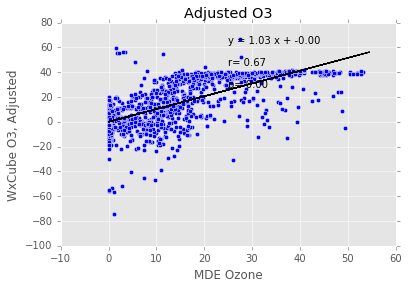

In [73]:
mod = result.params['so2']*so2df[col] + result.params['h2s']*h2sdf[col]+  result.params['no2']*no2df[col]#['2017-09-16'] 
x = mde['O3'].resample('15Min').mean()
y = -1* mod.resample('15Min').mean()

easy_scatter(x, y[x.index]+ 42.40, 'Adjusted O3', 'MDE Ozone', 'WxCube O3, Adjusted')

(1.0304505349645421, 0.66624301002987185, 8.5344186177698881e-141)

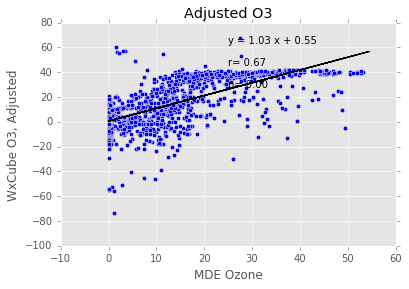

In [75]:
mod = result.params[0] + result.params['so2']*so2df[col] + result.params['h2s']*h2sdf[col]+  result.params['no2']*no2df[col]#['2017-09-16'] 
x = mde['O3'].resample('15Min').mean()
y = -1* mod.resample('15Min').mean()

easy_scatter(x, y[x.index]+ 42.40, 'Adjusted O3', 'MDE Ozone', 'WxCube O3, Adjusted')

In [77]:
(y[x.index]+ 42.40 - x).mean()

1.0536526088365534

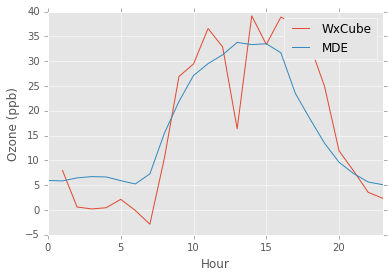

In [27]:
(-1*mod +42.4).groupby(mod.index.hour).mean().plot(label = 'WxCube')
mde['O3'].groupby(mde.index.hour).mean().plot(label = 'MDE')
plt.legend()
plt.xlabel('Hour')
plt.ylabel('Ozone (ppb)')

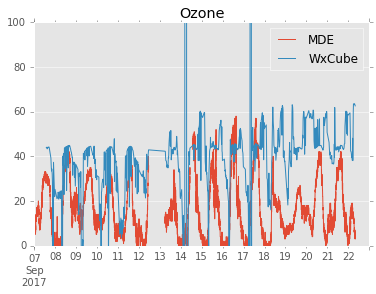

In [43]:
mde['O3'].plot(label  = 'MDE')
(-1*mod +42.4).dropna().plot(label = 'WxCube')
plt.title('Ozone')
plt.ylim([0,100])
plt.legend()

In [131]:
# do no2 sensors 
# averaging all of the sensors
regdf = pd.DataFrame()
regdf['o3'] = o3df['2017-09-16'].mean(axis = 1)
regdf['no2'] = no2df['2017-09-16'].mean(axis = 1)
regdf['so2'] = so2df['2017-09-16'].mean(axis = 1)
regdf['h2s'] = h2sdf['2017-09-16'].mean(axis = 1)
regdf['tru_o3'] = mde['O3']['2017-09-16']
regdf['tru_no2'] = mde['NO2(NOx)']['2017-09-16']
regdf['rh'] = mde['RH']['2017-09-16']
deltaRH = (mde['RH']['2017-09-16'].iloc[1:].values - mde['RH']['2017-09-16'].iloc[:-1].values)
regdf['drh'] = pd.Series(deltaRH, index = mde['2017-09-16'].iloc[:-1].index)

result = sm.ols(formula="no2 ~ tru_no2+ o3 + so2 + h2s", data=regdf).fit()
print(result.params)
print(result.summary())

Intercept    20.835668
tru_no2      -8.129923
o3            0.109793
so2          -0.289046
h2s          -2.584159
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     12.34
Date:                Mon, 25 Sep 2017   Prob (F-statistic):           7.64e-08
Time:                        00:32:03   Log-Likelihood:                -417.95
No. Observations:                  84   AIC:                             845.9
Df Residuals:                      79   BIC:                             858.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-

(-11.84540992306758, -1.0, 0.0)

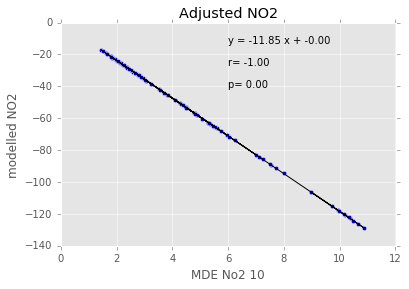

In [125]:
col = 10
mod =  result.params['tru_no2']*mde['NO2(NOx)']['2017-09-16'] #+ result.params['so2']*so2df[col]['2017-09-16']+  result.params['h2s']*h2sdf[col]['2017-09-16']+  result.params['o3']*o3df[col]['2017-09-16'] 
easy_scatter(mde['NO2(NOx)']['2017-09-16'].resample('15Min').mean(), 
             mod.resample('15Min').mean(), 
             'Adjusted NO2', 'MDE No2 %s'%col, 'modelled NO2')

In [88]:
result.params['tru_no2']

-8.1299233272482709

(-0.0091668799342078076, -0.0030684747751312403, 0.91739360206410492)

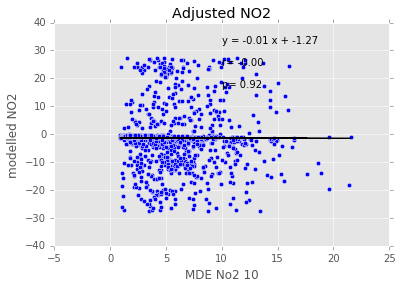

In [130]:
# all dates
mod = no2df[col]
x = mde['NO2(NOx)'].resample('15Min').mean()
y = 1/result.params['tru_no2']* mod.resample('15Min').mean()

easy_scatter(x, y[x.index], 
            'Adjusted NO2', 'MDE No2 %s'%col, 'modelled NO2')

In [ ]:
# all dates
mod =  result.params['so2']*so2df[col]+  result.params['h2s']*h2sdf[col]+  result.params['o3']*o3df[col]
x = mde['NO2(NOx)'].resample('15Min').mean()
y = 1/result.params['tru_no2']* mod.resample('15Min').mean()

easy_scatter(x, y[x.index], 
            'Adjusted NO2', 'MDE No2 %s'%col, 'modelled NO2')

(0.20154083235623571, 0.31479151385262621, 9.3502283012329655e-28)

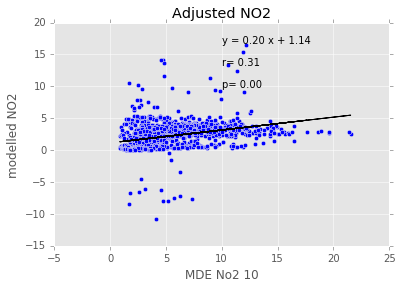

In [92]:
# all dates
mod =  result.params['so2']*so2df[col]+  result.params['h2s']*h2sdf[col]+  result.params['o3']*o3df[col]
x = mde['NO2(NOx)'].resample('15Min').mean()
y = 1/result.params['tru_no2']* mod.resample('15Min').mean()

easy_scatter(x, y[x.index], 
            'Adjusted NO2', 'MDE No2 %s'%col, 'modelled NO2')

(0.86308769214663816, 0.39013301391720218, 5.9032896023201777e-46)

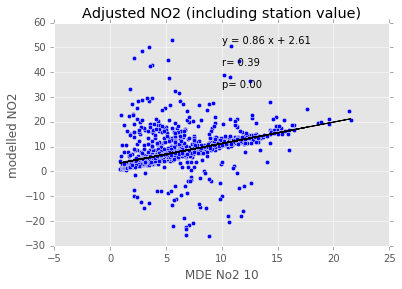

In [96]:
# all dates
mod =  result.params['tru_no2']*mde['NO2(NOx)'] +  result.params['so2']*so2df.mean(axis=1)+  result.params['h2s']*h2sdf.mean(axis=1)+  result.params['o3']*o3df.mean(axis=1)
x = mde['NO2(NOx)'].resample('15Min').mean()
y = 1/result.params['tru_no2']* mod.resample('15Min').mean()

easy_scatter(x, y[x.index], 
            'Adjusted NO2 (including station value)', 'MDE No2 %s'%col, 'modelled NO2')

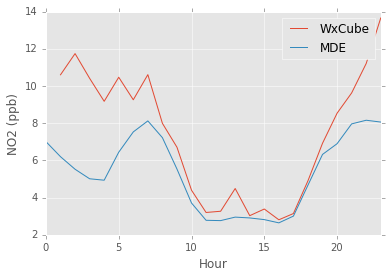

In [97]:
(1/result.params['tru_no2']*mod ).groupby(mod.index.hour).mean().plot(label = 'WxCube')
mde['NO2(NOx)'].groupby(mde.index.hour).mean().plot(label = 'MDE')
plt.legend()
plt.xlabel('Hour')
plt.ylabel('NO2 (ppb)')

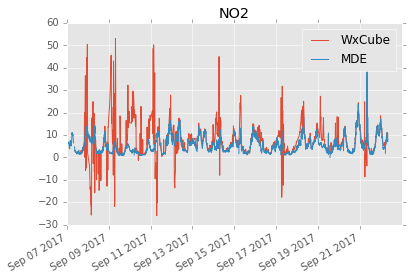

In [106]:
(1/result.params['tru_no2']*mod).dropna().plot(label = 'WxCube')
mde['NO2(NOx)'].plot(label = 'MDE')
plt.title('NO2')
plt.legend()

In [104]:
# mean difference
(mde['NO2(NOx)'] - (1/result.params['tru_no2']*mod)).mean()

-1.9189196482472104

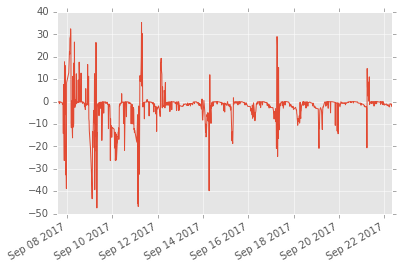

In [115]:
(mde['NO2(NOx)'] - (1/result.params['tru_no2']*mod)).dropna().plot()

In [140]:
o3df.max()

10    322.39
11    206.24
12    327.10
13    327.23
14    311.00
dtype: float64

In [3]:
meta.head()

,meta:instanceID,qr_ozone,qr_no2,qr_h2s,qr_so2,Location:Latitude,Location:Longitude,Location:Altitude,Location:Accuracy,sunorshade,photo,install_time,notes
id,,,,,,,,,,,,,
4,uuid:f737f3f3-5bf4-4766-bf8c-23a9b510c9fe,050217012308 110401 O3 1705 -10.97,071717010149 110501 NO2 1707 -29.47,071817010209 110303 H2S 1707 264.60,071217010736 110601 SO2 1707 39.20,39.324704,-76.629911,0.0,20.409,partial,https://bmorecoolodk.appspot.com/view/binaryDa...,Wed Aug 30 15:36:35 UTC 2017,Sierra Club
5,uuid:bdc909f9-1e0e-40e6-aadc-78bf8d3880a6,050217012305 110401 O3 1705 -13.24,071717010118 110501 NO2 1707 -30.15,071817010217 110303 H2S 1707 288.29,071217010745 110601 SO2 1707 41.09,39.324701,-76.629888,0.0,20.519,partial,https://bmorecoolodk.appspot.com/view/binaryDa...,Wed Aug 30 15:41:03 UTC 2017,Sierra Club
6,uuid:0b5ea5c2-e8ba-4e5f-8571-fa1428ec7269,050217012409 110401 O3 1705 -10.44,071717010117 110501 NO2 1707 -31.03,071817010229 110303 H2S 1707 270.97,071217010730 110601 SO2 1707 34.10,39.324704,-76.629911,0.0,20.355,partial,https://bmorecoolodk.appspot.com/view/binaryDa...,Wed Aug 30 15:44:56 UTC 2017,Sierra Club
7,uuid:aaa804dd-8f4b-441c-a980-598f35d3ba1d,050217012439 110401 O3 1705 -13.32,071717010456 110501 NO2 1707 -37.16,071817010225 110303 H2S 1707 247.44,071217010753 110601 SO2 1707 38.78,39.324704,-76.629911,0.0,20.364,partial,https://bmorecoolodk.appspot.com/view/binaryDa...,Wed Aug 30 15:48:40 UTC 2017,Sierra Club
3,uuid:9881762e-9151-4d72-9d7f-7dcadad44c01,050217012331 110401 O3 1705 -14.5,071717010128 110501 NO2 1707 -28.30,071817010256 110303 H2S 1707 280.73,071217010716 110601 SO2 1707 29.07,39.324704,-76.629911,0.0,20.368,partial,https://bmorecoolodk.appspot.com/view/binaryDa...,Wed Aug 30 15:52:24 UTC 2017,Sierra Club


In [270]:
meta.loc[sel_id]['qr_ozone']

'050217012431 110401 O3 1705 -13.64'

,H2S_avg,H2S_std,NO2_avg,NO2_std,O3_avg,O3_std,SO2_avg,SO2_std,battAV,hum1,hum2,hum3,id,temp1,temp2,temp3,timest
0,-3,0,848,2,0,0,-3,0,"505,1358,907,45,",6073,5817,5962,11,2420,2433,2457,20170908171150
1,-3,0,848,2,0,0,-3,0,"505,1358,907,45,",6073,5817,5962,11,2420,2433,2457,20170908171156
2,-3,0,850,5,0,0,-3,0,"505,1404,907,45,",6023,5771,5917,11,2435,2448,2468,20170908171215
3,-3,0,888,19,0,0,-3,0,"505,1420,907,45,",5976,5727,5875,11,2444,2457,2474,20170908171234
4,-3,0,955,7,0,0,-3,0,"505,1436,907,45,",5935,5689,5838,11,2449,2462,2477,20170908171254
5,-3,0,1016,6,0,0,-2,0,"505,1452,907,45,",5900,5658,5807,11,2451,2464,2477,20170908171313
6,-3,0,1010,13,0,0,-3,0,"505,1504,907,45,",5869,5629,5778,11,2452,2466,2478,20170908171333
7,-3,0,940,17,0,0,-3,0,"505,1520,907,45,",5832,5595,5746,11,2459,2472,2482,20170908171352
8,-3,0,877,2,0,0,-3,0,"505,1536,907,45,",5792,5558,5710,11,2467,2481,2487,20170908171411
9,-3,0,847,2,0,0,-3,0,"505,1552,907,45,",5744,5513,5668,11,2479,2492,2496,20170908171431


In [304]:
aq_df.append(df)

,H2S_avg,H2S_std,NO2_avg,NO2_std,O3_avg,O3_std,SO2_avg,SO2_std,battAV,hum1,hum2,hum3,id,temp1,temp2,temp3,timest
0,-3,0,848,2,0,0,-3,0,"505,1358,907,45,",6073,5817,5962,11.0,2420,2433,2457,20170908171150
1,-3,0,848,2,0,0,-3,0,"505,1358,907,45,",6073,5817,5962,11.0,2420,2433,2457,20170908171156
2,-3,0,850,5,0,0,-3,0,"505,1404,907,45,",6023,5771,5917,11.0,2435,2448,2468,20170908171215
3,-3,0,888,19,0,0,-3,0,"505,1420,907,45,",5976,5727,5875,11.0,2444,2457,2474,20170908171234
4,-3,0,955,7,0,0,-3,0,"505,1436,907,45,",5935,5689,5838,11.0,2449,2462,2477,20170908171254
5,-3,0,1016,6,0,0,-2,0,"505,1452,907,45,",5900,5658,5807,11.0,2451,2464,2477,20170908171313
6,-3,0,1010,13,0,0,-3,0,"505,1504,907,45,",5869,5629,5778,11.0,2452,2466,2478,20170908171333
7,-3,0,940,17,0,0,-3,0,"505,1520,907,45,",5832,5595,5746,11.0,2459,2472,2482,20170908171352
8,-3,0,877,2,0,0,-3,0,"505,1536,907,45,",5792,5558,5710,11.0,2467,2481,2487,20170908171411
9,-3,0,847,2,0,0,-3,0,"505,1552,907,45,",5744,5513,5668,11.0,2479,2492,2496,20170908171431


In [299]:
len(response['Items'])

1351

In [339]:
# beltsville = 10,11,12,13,14, 18 (continuous)
aq_df = pd.DataFrame()
for sel_id in (10,11,12,13,14): 
    #sel_id = 11
    m_o3 = float(meta.loc[sel_id]['qr_ozone'][28:])
    m_no2 = float(meta.loc[sel_id]['qr_no2'][28:])
    m_h2s = float(meta.loc[sel_id]['qr_h2s'][28:])
    m_so2= float(meta.loc[sel_id]['qr_so2'][28:])

    response = table.query(
                KeyConditionExpression=Key('id').eq(str(sel_id)) & Key('timest').gt(20170908000015)
            )
    df = pd.DataFrame(response['Items'])
    ## convert post timestamp to datetime
    df['timest'] = [pd.to_datetime(str(date)[:-4], format = '%Y%m%d%H%M') for date in df['timest']]
    # read in batteryAV to get the time
    df[['something', 'HourMinute', 'MonthDay', 'AV', 'drop'] ] = df['battAV'].str.split(',').apply(pd.Series)

    df[['O3_avg', 'O3_std']]   = df[['O3_avg', 'O3_std']].astype(float).multiply(0.01* m_o3)
    df[['NO2_avg', 'NO2_std']] = df[['NO2_avg', 'NO2_std']].astype(float).multiply(0.01*m_no2)
    df[['SO2_avg', 'SO2_std']] = df[['SO2_avg', 'SO2_std']].astype(float).multiply(0.01* m_so2)
    df[['H2S_avg', 'H2S_std']] = df[['H2S_avg', 'H2S_std']].astype(float).multiply(0.01* m_h2s)

    # set up time index 
    date_index = []
    for date in df[['MonthDay', 'HourMinute']].values : 
        try: 
            if date[0] == '32767' : 
                date_index.append(np.nan)
            elif date[0] == '0' : 
                date_index.append(np.nan)
            else:
                date_index.append(pd.to_datetime('2017' +date[0]+date[1], format = '%Y%m%d%H%M'))
        except ValueError:  
            date_index.append(np.nan)

    df['date_index'] = date_index
    aq_df = aq_df.append(df.loc[pd.notnull(df['date_index'])])

In [343]:
aq_df = aq_df.set_index(['id', 'date_index'])

In [344]:
aq_df.head()

H2S_avg  H2S_std   NO2_avg  NO2_std  O3_avg  O3_std  \
id date_index                                                                  
10 2017-09-07 13:55:00  297.7200   5.9544 -279.4880  -1.5880    -0.0    -0.0   
   2017-09-07 14:04:00  279.8568   2.9772 -274.4064  -2.2232    -0.0    -0.0   
   2017-09-07 14:19:00  267.9480   5.9544 -268.6896  -1.9056    -0.0    -0.0   
   2017-09-07 14:35:00  354.2868   2.9772 -296.6384  -1.5880    -0.0    -0.0   
   2017-09-07 14:51:00  422.7624   8.9316 -315.3768  -1.9056    -0.0    -0.0   

                        SO2_avg  SO2_std            battAV  hum1 ...   hum3  \
id date_index                                                    ...          
10 2017-09-07 13:55:00    54.12     1.23  514,1355,907,45,  4198 ...   4395   
   2017-09-07 14:04:00    48.38     0.41  514,1404,907,45,  4146 ...   4348   
   2017-09-07 14:19:00    45.92     0.82  514,1419,907,45,  4083 ...   4293   
   2017-09-07 14:35:00    70.11     0.82  514,1435,907,45,  4056 ...   4272   
   2017-09-07 14:51:00    87.33     1.64  514,1451,907,45,  4050 ...   4271   

                       temp1 temp2 temp3              timest something  \
id date_index                                                            
10 2017-09-07 13:55:00  2644  2652  2570 2017-09-08 01:07:00       514   
   2017-09-07 14:04:00  2666  2674  2589 2017-09-08 01:07:00       514   
   2017-09-07 14:19:00  2689  2697  2606 2017-09-08 01:07:00       514   
   2017-09-07 14:35:00  2694  2702  2608 2017-09-08 01:07:00       514   
   2017-09-07 14:51:00  2688  2696  2600 2017-09-08 01:07:00       514   

                       HourMinute MonthDay  AV drop  
id date_index                                        
10 2017-09-07 13:55:00       1355      907  45       
   2017-09-07 14:04:00       1404      907  45       
   2017-09-07 14:19:00       1419      907  45       
   2017-09-07 14:35:00       1435      907  45       
   2017-09-07 14:51:00       1451      907  45       

[5 rows x 21 columns]

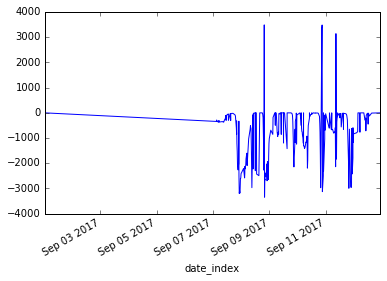

In [405]:
df.loc[pd.notnull(df['date_index'])].set_index('date_index')['O3_avg'].plot()

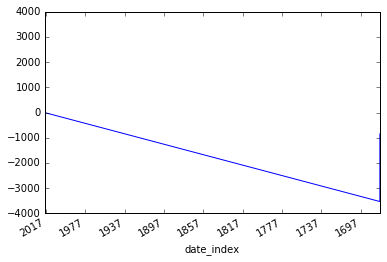

In [404]:
df.set_index('date_index')['O3_avg'].plot()

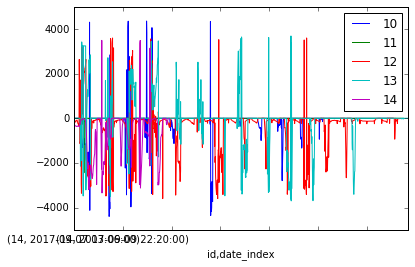

In [350]:
handles = aq_df['O3_avg'].groupby(aq_df.index.get_level_values('id')).plot()
plt.legend()

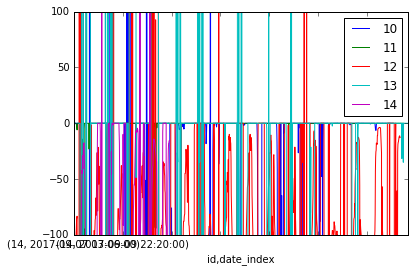

In [372]:
for i in (10,11,12,13,14) : 
    aq_df['O3_avg'].loc[ aq_df.index.get_level_values('id') == str(i) ].plot(label = i)
plt.legend()

In [386]:
a = aq_df['O3_avg'].reset_index().set_index('date_index').resample('15T').mean()
a.shape

(20537, 1)

(736579.1291666667, 736584.5131944445)

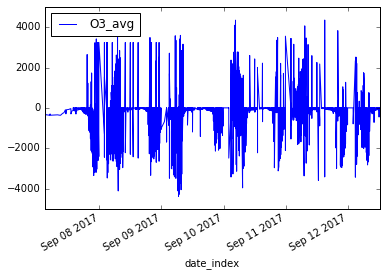

In [400]:
aq_df['O3_avg'].reset_index().set_index('date_index').plot()
plt.xlim(df['date_index'].dropna().iloc[0], df['date_index'].dropna().iloc[-1])

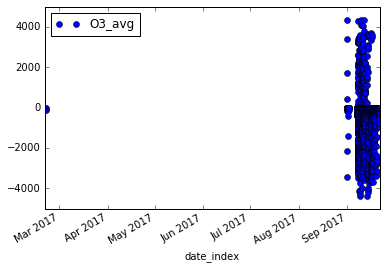

In [402]:
aq_df['O3_avg'].reset_index().set_index('date_index').plot(style = 'o')

In [356]:
aq_df['O3_avg'].groupby(aq_df.index.get_level_values('id'))

In [338]:
df.set_index()

DatetimeIndex([                'NaT',                 'NaT',
                               'NaT',                 'NaT',
                               'NaT',                 'NaT',
                               'NaT',                 'NaT',
                               'NaT',                 'NaT',
               ...
               '2017-09-12 09:52:00', '2017-09-12 10:04:00',
               '2017-09-12 10:20:00', '2017-09-12 10:52:00',
               '2017-09-12 11:04:00', '2017-09-12 11:20:00',
               '2017-09-12 11:36:00', '2017-09-12 11:52:00',
               '2017-09-12 12:03:00', '2017-09-12 12:19:00'],
              dtype='datetime64[ns]', length=451, freq=None)

In [327]:
df1 = df.copy()

In [333]:
aq_df = aq_df.append(df.loc[pd.notnull(df.index)])
aq_df.head()

,H2S_avg,H2S_std,NO2_avg,NO2_std,O3_avg,O3_std,SO2_avg,SO2_std,battAV,hum1,...,id,temp1,temp2,temp3,timest,something,HourMinute,MonthDay,AV,drop
2017-09-07 03:06:00,-8.5233,0.0,4167.0576,-1040.5800,-283.9564,-22.1656,202.0914,36.0318,"552,36,907,45,",6129,...,14,2597,2611,2484,2017-09-08 01:07:00,552,36,907,45,
2017-09-07 05:02:00,-8.5233,0.0,2209.0752,-52.4520,-300.4192,-0.4304,207.5745,0.5222,"517,52,907,45,",6272,...,14,2539,2552,2490,2017-09-08 01:07:00,517,52,907,45,
2017-09-07 11:09:00,-8.5233,0.0,1006.7400,-44.6688,-298.3748,-0.9684,213.8409,0.2611,"517,119,907,45,",6412,...,14,2486,2497,2481,2017-09-08 01:07:00,517,119,907,45,
2017-09-07 13:05:00,-8.5233,0.0,254.1384,-64.6344,-300.0964,-0.8608,216.1908,0.5222,"517,135,907,45,",6466,...,14,2468,2478,2473,2017-09-08 01:07:00,517,135,907,45,
2017-09-07 15:01:00,-8.5233,0.0,-453.1176,-80.2008,-305.4764,-0.8608,218.0185,0.5222,"517,151,907,45,",6514,...,14,2453,2463,2465,2017-09-08 01:07:00,517,151,907,45,


In [321]:
aq_df.append(df.loc[pd.notnull(df.index)])

,H2S_avg,H2S_std,NO2_avg,NO2_std,O3_avg,O3_std,SO2_avg,SO2_std,battAV,hum1,...,id,temp1,temp2,temp3,timest,something,HourMinute,MonthDay,AV,drop
2017-09-07 03:06:00,-8.5233,0.0000,4167.0576,-1040.5800,-283.9564,-22.1656,202.0914,36.0318,"552,36,907,45,",6129,...,14,2597,2611,2484,2017-09-08 01:07:00,552,36,907,45,
2017-09-07 05:02:00,-8.5233,0.0000,2209.0752,-52.4520,-300.4192,-0.4304,207.5745,0.5222,"517,52,907,45,",6272,...,14,2539,2552,2490,2017-09-08 01:07:00,517,52,907,45,
2017-09-07 11:09:00,-8.5233,0.0000,1006.7400,-44.6688,-298.3748,-0.9684,213.8409,0.2611,"517,119,907,45,",6412,...,14,2486,2497,2481,2017-09-08 01:07:00,517,119,907,45,
2017-09-07 13:05:00,-8.5233,0.0000,254.1384,-64.6344,-300.0964,-0.8608,216.1908,0.5222,"517,135,907,45,",6466,...,14,2468,2478,2473,2017-09-08 01:07:00,517,135,907,45,
2017-09-07 15:01:00,-8.5233,0.0000,-453.1176,-80.2008,-305.4764,-0.8608,218.0185,0.5222,"517,151,907,45,",6514,...,14,2453,2463,2465,2017-09-08 01:07:00,517,151,907,45,
2017-09-07 20:04:00,-8.5233,0.0000,-1130.5944,-70.0488,-318.0656,-0.5380,218.8018,0.5222,"517,204,907,45,",6554,...,14,2441,2451,2458,2017-09-08 01:07:00,517,204,907,45,
2017-09-07 22:00:00,-8.5233,0.0000,-1441.5840,-75.1248,-328.8256,-0.5380,219.5851,0.2611,"517,220,907,45,",6588,...,14,2431,2441,2452,2017-09-08 01:07:00,517,220,907,45,
2017-09-07 02:52:00,-8.5233,0.0000,-2084.2056,-93.7368,-339.6932,-1.0760,221.4128,0.2611,"517,252,907,45,",6646,...,14,2415,2425,2441,2017-09-08 01:07:00,517,252,907,45,
2017-09-07 03:04:00,-8.5233,0.0000,-2193.1704,-88.3224,-340.1236,-0.6456,221.9350,0.2611,"517,304,907,45,",6671,...,14,2409,2419,2437,2017-09-08 01:07:00,517,304,907,45,
2017-09-07 03:36:00,-8.5233,2.8411,-2635.7976,-92.0448,-347.4404,-0.7532,222.7183,0.5222,"517,336,907,45,",6713,...,14,2398,2408,2429,2017-09-08 01:07:00,517,336,907,45,


(736579.5819444444, 736593.536111111)

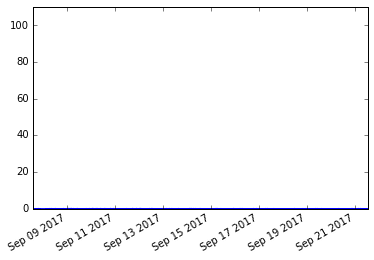

In [290]:
df['O3_avg'].astype(float).plot()
plt.ylim([0,110])
plt.xlim([df.index[0], df.index[-1]])

In [413]:
sel_id = 10
m_o3 = float(meta.loc[sel_id]['qr_ozone'][28:])
m_no2 = float(meta.loc[sel_id]['qr_no2'][28:])
m_h2s = float(meta.loc[sel_id]['qr_h2s'][28:])
m_so2= float(meta.loc[sel_id]['qr_so2'][28:])

response = table.query(
            KeyConditionExpression=Key('id').eq(str(sel_id)) & Key('timest').gt(20170908000015)
        )
df = pd.DataFrame(response['Items'])
## convert post timestamp to datetime
df['timest'] = [pd.to_datetime(str(date)[:-4], format = '%Y%m%d%H%M') for date in df['timest']]
# read in batteryAV to get the time
df[['something', 'HourMinute', 'MonthDay', 'AV', 'drop'] ] = df['battAV'].str.split(',').apply(pd.Series)

df[['O3_avg', 'O3_std']]   = df[['O3_avg', 'O3_std']].astype(float).multiply(0.01* m_o3)
df[['NO2_avg', 'NO2_std']] = df[['NO2_avg', 'NO2_std']].astype(float).multiply(0.01*m_no2)
df[['SO2_avg', 'SO2_std']] = df[['SO2_avg', 'SO2_std']].astype(float).multiply(0.01* m_so2)
df[['H2S_avg', 'H2S_std']] = df[['H2S_avg', 'H2S_std']].astype(float).multiply(0.01* m_h2s)

# set up time index 
date_index = []
for date in df[['MonthDay', 'HourMinute']].values : 
    try: 
        if date[0] == '32767' : 
            date_index.append(np.nan)
        elif date[0] == '0' : 
            date_index.append(np.nan)
        else:
            date_index.append(pd.to_datetime('2017' +date[0]+date[1], format = '%Y%m%d%H%M'))
    except ValueError:  
        date_index.append(np.nan)

df['date_index'] = date_index
df = df.set_index('date_index')

(-100, 200)

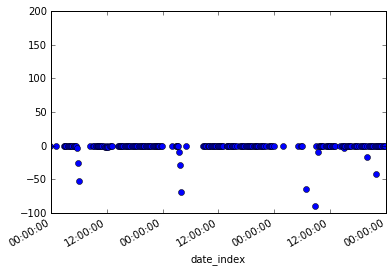

In [416]:
df['O3_avg'].astype(float).plot(style = 'o')
plt.xlim(['2017-09-15', '2017-09-18'])

plt.ylim([-100,200])

In [7]:
ids = (10,11,12,13,14)
o3df = pd.DataFrame()
o3stddf = pd.DataFrame()
for sel_id in ids : 
    #sel_id = 10
    m_o3 = float(meta.loc[sel_id]['qr_ozone'][28:])
    m_no2 = float(meta.loc[sel_id]['qr_no2'][28:])
    m_h2s = float(meta.loc[sel_id]['qr_h2s'][28:])
    m_so2= float(meta.loc[sel_id]['qr_so2'][28:])

    response = table.query(
                KeyConditionExpression=Key('id').eq(str(sel_id)) & Key('timest').gt(20170908000015)
            )
    df = pd.DataFrame(response['Items'])
    ## convert post timestamp to datetime
    df['timest'] = [pd.to_datetime(str(date)[:-4], format = '%Y%m%d%H%M') for date in df['timest']]
    # read in batteryAV to get the time
    df[['something', 'HourMinute', 'MonthDay', 'AV', 'drop'] ] = df['battAV'].str.split(',').apply(pd.Series)

    df[['O3_avg', 'O3_std']]   = df[['O3_avg', 'O3_std']].astype(float).multiply(0.01* m_o3)
    df[['NO2_avg', 'NO2_std']] = df[['NO2_avg', 'NO2_std']].astype(float).multiply(0.01*m_no2)
    df[['SO2_avg', 'SO2_std']] = df[['SO2_avg', 'SO2_std']].astype(float).multiply(0.01* m_so2)
    df[['H2S_avg', 'H2S_std']] = df[['H2S_avg', 'H2S_std']].astype(float).multiply(0.01* m_h2s)

    # set up time index 
    date_index = []
    for date in df[['MonthDay', 'HourMinute']].values : 
        try: 
            if date[0] == '32767' : 
                date_index.append(np.nan)
            elif date[0] == '0' : 
                date_index.append(np.nan)
            else:
                date_index.append(pd.to_datetime('2017' +date[0]+date[1], format = '%Y%m%d%H%M'))
        except ValueError:  
            date_index.append(np.nan)

    df['date_index'] = date_index
    df.index = pd.DatetimeIndex(date_index, freq = '15Min')
    df = df.loc['2017-09-07':]
    #o3df = o3df.append(df['O3_avg'].rename(columns={"O3_avg": sel_id}))
    o3df[sel_id] = df['O3_avg'].resample('15Min').mean().rename(columns={"O3_avg": sel_id})
    o3stddf[sel_id] = df['O3_std'].resample('15Min').mean().rename(columns={"O3_std": sel_id})

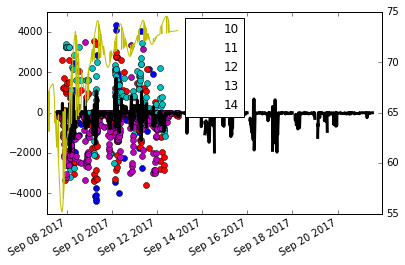

In [661]:
o3df.dropna().plot(style = 'o')
o3df.mean(axis=1).plot(linewidth = 3, color = 'k')
df[['hum1', 'hum2', 'hum3']].astype(float).multiply(0.01).mean(axis=1).plot(secondary_y = True)
#plt.legend(loc = 1)#bbox_to_anchor=(1.25, 1.05))

(-200, 200)

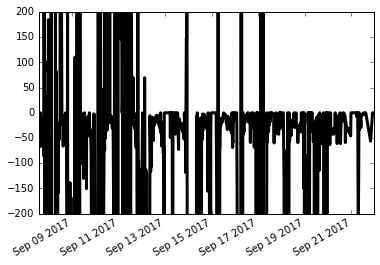

In [664]:
o3df.mean(axis=1).dropna().plot(linewidth = 3, color = 'k')
plt.ylim([-200,200])

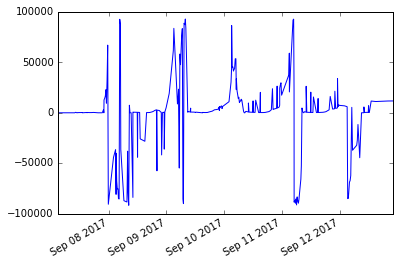

In [640]:
df['H2S_avg'].plot()

(0.0044314585200246684, 0.12890324587123753, 0.01072946100744156)

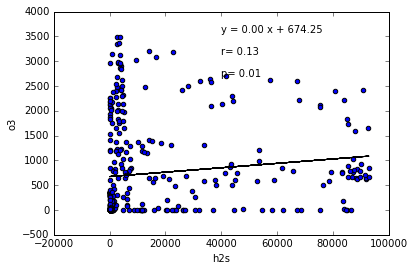

In [643]:
easy_scatter(abs(df['H2S_avg']), abs(df['O3_avg']), '', 'h2s', 'o3')

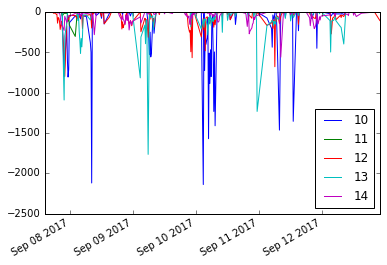

In [629]:
o3stddf.dropna().plot()

In [637]:
o3df.mean()

10   -109.529569
11     -4.322105
12   -333.660447
13    -18.306328
14   -699.348186
dtype: float64

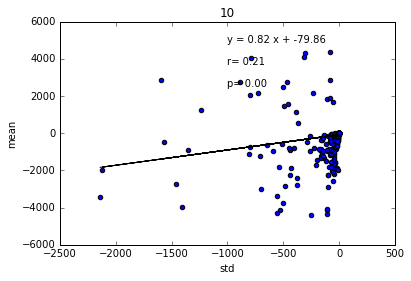

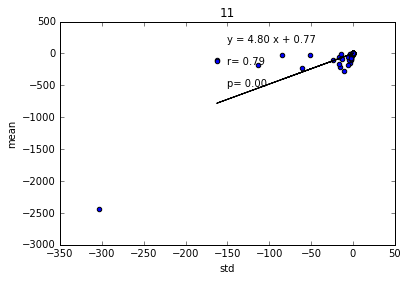

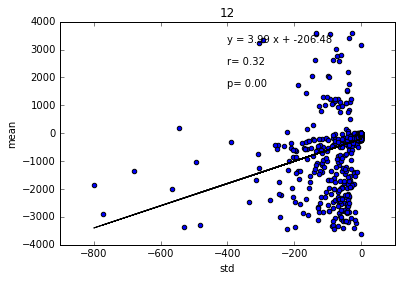

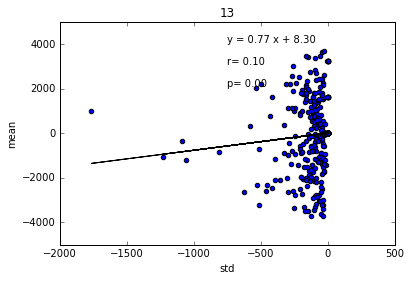

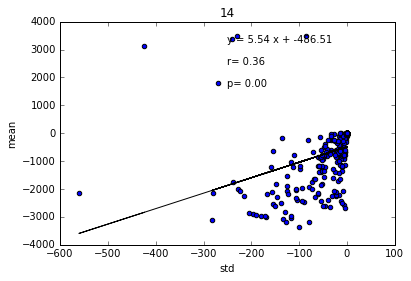

In [636]:
for sel_id in ids :
    plt.figure()
    easy_scatter( o3stddf[sel_id],o3df[sel_id], sel_id,  'std','mean',)

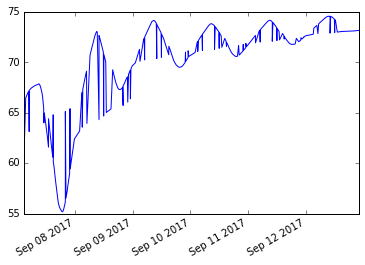

In [616]:
df[['hum1', 'hum2', 'hum3']].astype(float).multiply(0.01).mean(axis=1).plot()

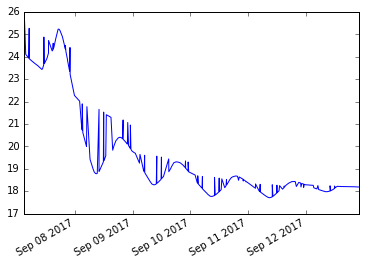

In [615]:
df[['temp1', 'temp2', 'temp3']].astype(float).multiply(0.01).mean(axis=1).plot()

In [20]:
import scipy.stats
def easy_scatter(x,y,title='', xlabel='', ylabel='') : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    #r = np.corrcoef(x[ind], y[ind])[0,1]
    r,p = scipy.stats.pearsonr(x[ind], y[ind])
    plt.scatter(x,y)
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r= %.2f'%r, xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p= %.2f'%p, xy=(.5, .7), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

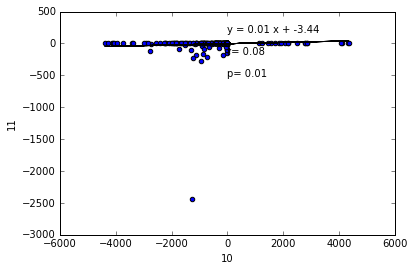

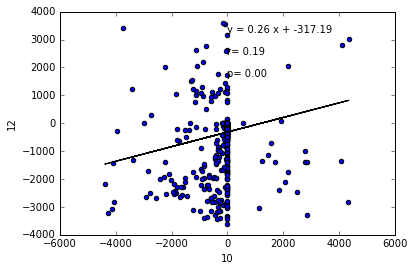

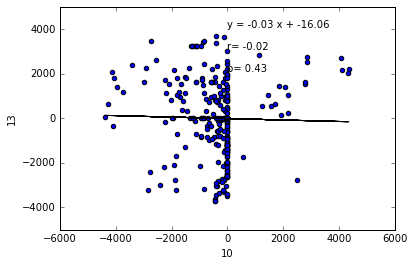

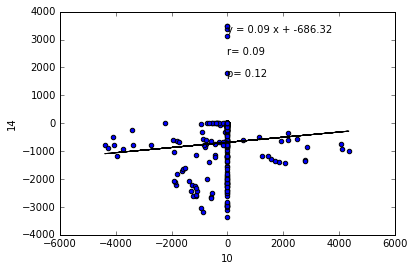

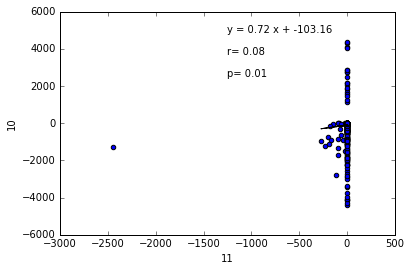

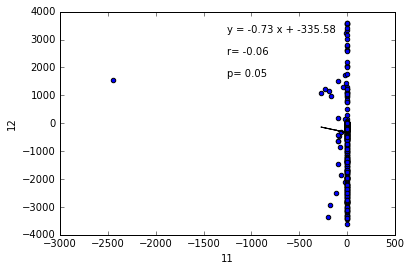

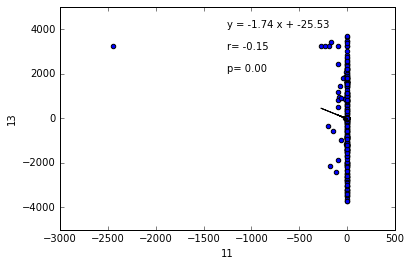

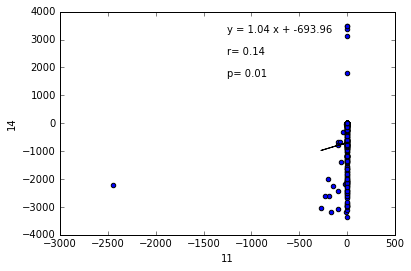

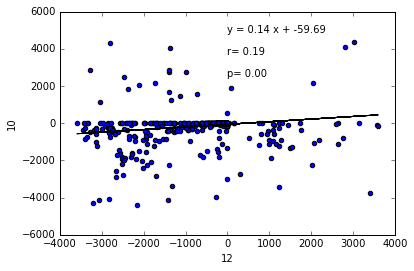

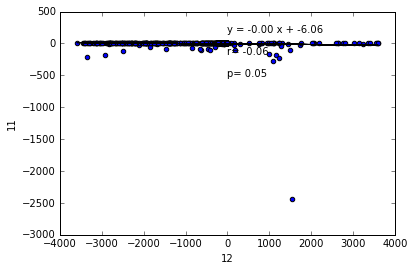

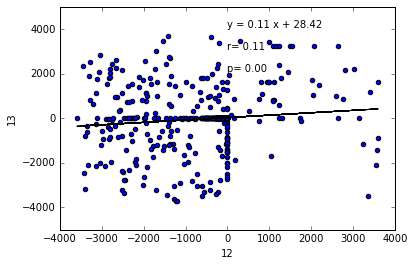

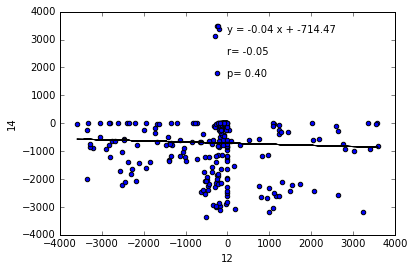

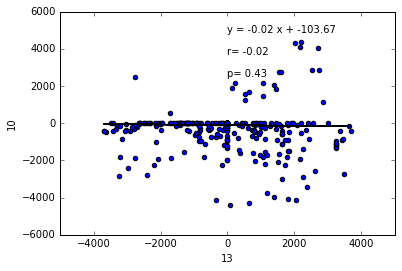

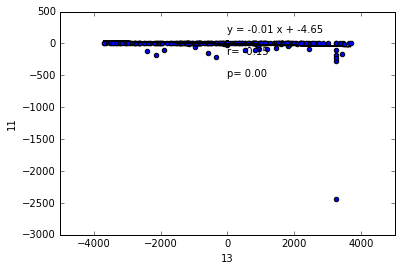

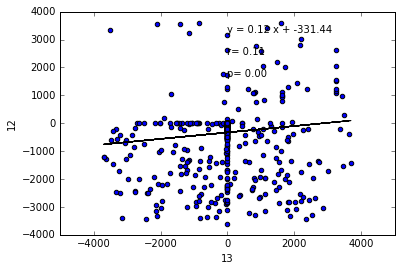

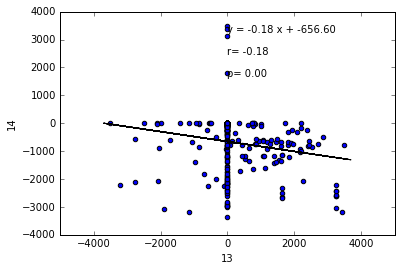

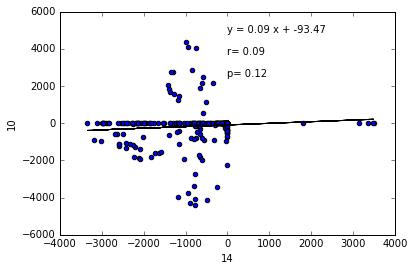

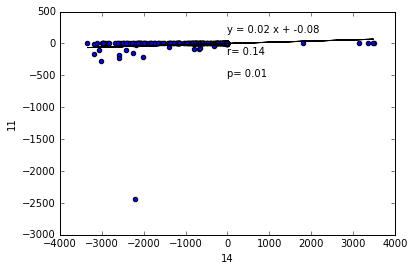

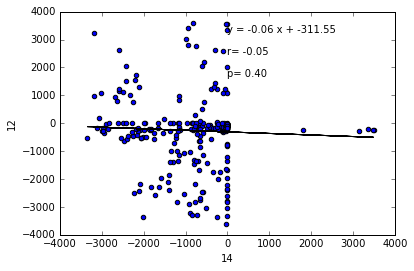

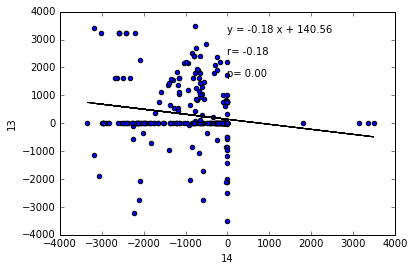

In [611]:
for id1 in ids :
    for id2 in ids: 
        if id1 != id2 : 
            plt.figure()
            easy_scatter(o3df[id1], o3df[id2], '', id1, id2)

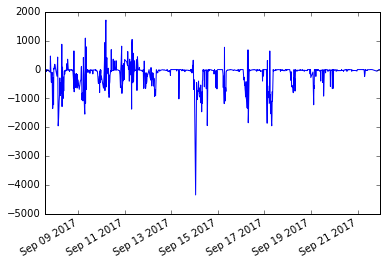

In [606]:
o3df.mean(axis=1).dropna().plot()

In [594]:
o3df[sel_id] = df['O3_avg'].resample('15Min').mean().rename(columns={"O3_avg": sel_id})

In [586]:
t_index = pd.date_range(date_index[0], date_index[-1], freq='15T')
test = pd.DataFrame(index = t_index)

In [589]:
df.iloc[0:15,0]

2017-09-07 13:55:00    297.7200
2017-09-07 14:04:00    279.8568
2017-09-07 14:19:00    267.9480
2017-09-07 14:35:00    354.2868
2017-09-07 14:51:00    422.7624
2017-09-07 15:04:00    413.8308
2017-09-07 15:20:00    384.0588
2017-09-07 15:36:00    315.5832
2017-09-07 15:52:00    270.9252
2017-09-07 16:04:00    264.9708
2017-09-07 16:20:00    256.0392
2017-09-07 16:36:00    244.1304
2017-09-07 16:52:00    250.0848
2017-09-07 17:20:00    378.1044
2017-09-07 17:36:00    506.1240
Name: H2S_avg, dtype: float64

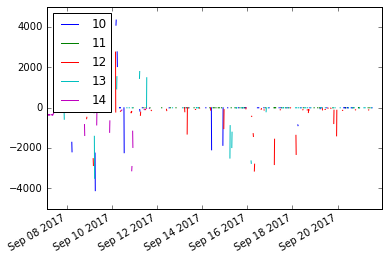

In [564]:
o3df.plot()

In [556]:
o3df = pd.DataFrame()
a = df.resample('15T').mean()[['O3_avg']].rename(columns={"O3_avg": sel_id})

In [561]:
o3df = pd.DataFrame()
o3df = o3df.append(df.resample('15T').mean()[['O3_avg']].rename(columns={"O3_avg": sel_id}))
o3df.head()

,14
2017-09-07 02:45:00,-339.6932
2017-09-07 03:00:00,-312.0400
2017-09-07 03:15:00,NaN
2017-09-07 03:30:00,-347.4404
2017-09-07 03:45:00,-347.6556


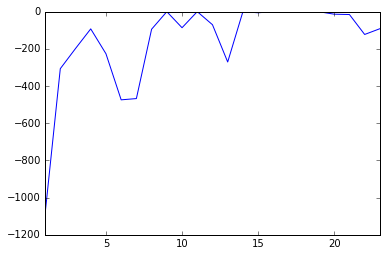

In [496]:
df['O3_avg'].groupby(df.index.hour).mean().plot()

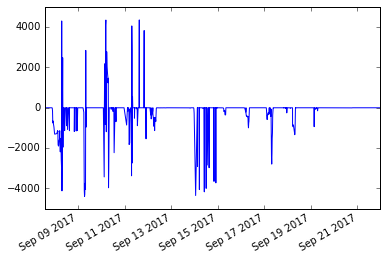

In [491]:
df.loc['2017-09-07':, 'O3_avg'].plot()

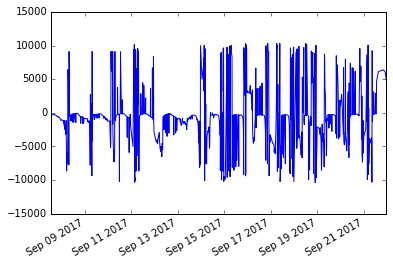

In [492]:
df.loc['2017-09-07':, 'NO2_avg'].plot()

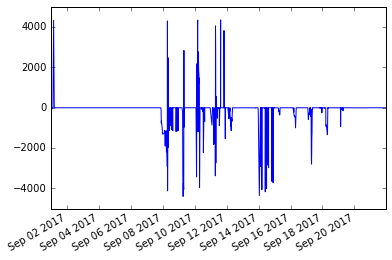

In [474]:
df.loc[pd.notnull(df['date_index']), 'O3_avg'].plot()

In [485]:
df['2017-09-10']

,H2S_avg,H2S_std,NO2_avg,NO2_std,O3_avg,O3_std,SO2_avg,SO2_std,battAV,hum1,...,temp1,temp2,temp3,timest,something,HourMinute,MonthDay,AV,drop,date_index
2017-09-10 02:00:00,4004.3340,128.0196,-1186.5536,-107.3488,-0.0000,-0.1364,941.36,31.57,"514,20,910,45,",7035,...,1853,1860,1834,2017-09-10 01:07:00,514,20,910,45,,2017-09-10 02:00:00
2017-09-10 05:02:00,4031.1288,38.7036,-1672.1640,-44.1464,-4.0920,-18.5504,990.56,36.49,"514,52,910,45,",7059,...,1845,1852,1827,2017-09-10 01:07:00,514,52,910,45,,2017-09-10 05:02:00
2017-09-10 10:04:00,4063.8780,53.5896,3780.0752,-2053.6016,-72.4284,-30.8264,1346.85,69.29,"514,104,910,45,",7071,...,1841,1849,1824,2017-09-10 01:07:00,514,104,910,45,,2017-09-10 10:04:00
2017-09-10 12:00:00,4051.9692,44.6580,-10216.8744,-1103.0248,-182.2304,-33.4180,1819.58,61.91,"514,120,910,45,",7082,...,1838,1845,1821,2017-09-10 01:07:00,514,120,910,45,,2017-09-10 12:00:00
2017-09-10 13:06:00,3989.4480,50.6124,9107.4976,-0.0000,-2228.6396,-95.7528,1746.19,45.92,"514,136,910,45,",7094,...,1834,1841,1817,2017-09-10 01:07:00,514,136,910,45,,2017-09-10 13:06:00
2017-09-10 15:02:00,3980.5164,50.6124,1936.7248,-5700.2848,-687.0468,-310.0372,1555.95,38.54,"514,152,910,45,",7106,...,1830,1838,1814,2017-09-10 01:07:00,514,152,910,45,,2017-09-10 15:02:00
2017-09-10 20:04:00,3980.5164,32.7492,-3666.6920,-434.1592,-0.0000,-0.1364,1337.83,54.94,"514,204,910,45,",7117,...,1827,1834,1811,2017-09-10 01:07:00,514,204,910,45,,2017-09-10 20:04:00
2017-09-10 22:00:00,4025.1744,139.9284,-5906.7248,-3511.7032,-3.4100,-11.8668,1278.79,113.98,"514,220,910,45,",7129,...,1823,1830,1807,2017-09-10 01:07:00,514,220,910,45,,2017-09-10 22:00:00
2017-09-10 23:06:00,4013.2656,35.7264,-231.5304,-210.2512,0.1364,-0.1364,1226.31,47.56,"514,236,910,45,",7140,...,1819,1826,1804,2017-09-10 01:07:00,514,236,910,45,,2017-09-10 23:06:00
2017-09-10 02:52:00,4010.2884,44.6580,-5173.3864,-9077.9608,-3430.0508,-2140.1160,1349.72,70.52,"514,252,910,45,",7151,...,1815,1823,1801,2017-09-10 01:07:00,514,252,910,45,,2017-09-10 02:52:00


In [439]:
df.head()

,H2S_avg,H2S_std,NO2_avg,NO2_std,O3_avg,O3_std,SO2_avg,SO2_std,battAV,hum1,...,temp1,temp2,temp3,timest,something,HourMinute,MonthDay,AV,drop,date_index
2017-09-07 13:55:00,297.7200,5.9544,-279.4880,-1.5880,-0.0,-0.0,54.12,1.23,"514,1355,907,45,",4198,...,2644,2652,2570,2017-09-08 01:07:00,514,1355,907,45,,2017-09-07 13:55:00
2017-09-07 14:04:00,279.8568,2.9772,-274.4064,-2.2232,-0.0,-0.0,48.38,0.41,"514,1404,907,45,",4146,...,2666,2674,2589,2017-09-08 01:07:00,514,1404,907,45,,2017-09-07 14:04:00
2017-09-07 14:19:00,267.9480,5.9544,-268.6896,-1.9056,-0.0,-0.0,45.92,0.82,"514,1419,907,45,",4083,...,2689,2697,2606,2017-09-08 01:07:00,514,1419,907,45,,2017-09-07 14:19:00
2017-09-07 14:35:00,354.2868,2.9772,-296.6384,-1.5880,-0.0,-0.0,70.11,0.82,"514,1435,907,45,",4056,...,2694,2702,2608,2017-09-08 01:07:00,514,1435,907,45,,2017-09-07 14:35:00
2017-09-07 14:51:00,422.7624,8.9316,-315.3768,-1.9056,-0.0,-0.0,87.33,1.64,"514,1451,907,45,",4050,...,2688,2696,2600,2017-09-08 01:07:00,514,1451,907,45,,2017-09-07 14:51:00


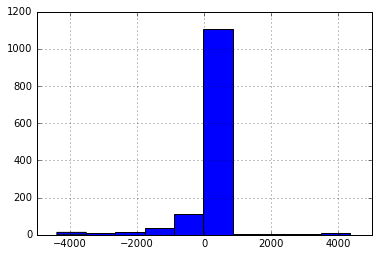

In [477]:
df['O3_avg'].hist()

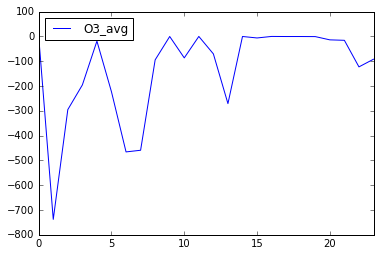

In [462]:
df.groupby(df.index.hour).mean()[['O3_avg']].plot()

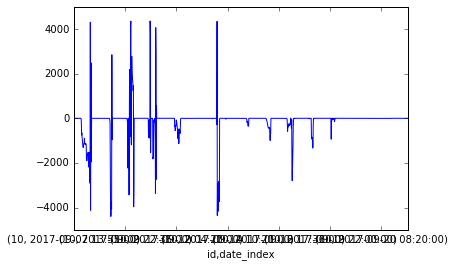

In [420]:
aq_df['O3_avg'].loc[ aq_df.index.get_level_values('id') == str(sel_id) ].plot(label = sel_id)

In [455]:
pd.__version__

u'0.18.1'

In [457]:
# setup a data frame with a multiindex


(736579.5819444444, 736593.536111111)

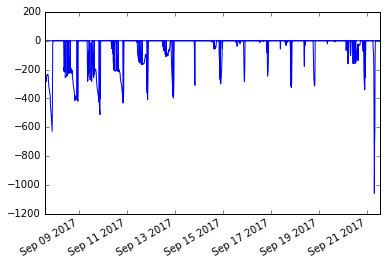

In [296]:
df['NO2_avg'].astype(float).plot()
#plt.ylim([0,110])
plt.xlim([df.index[0], df.index[-1]])

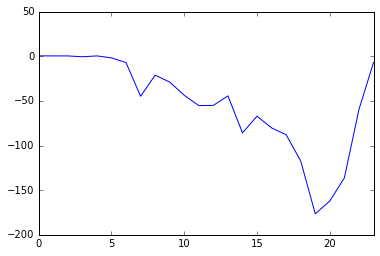

In [295]:
df['NO2_avg'].groupby(df.index.hour).mean().plot()

In [59]:
ids = (10,11,12,13,14)
o3df = pd.DataFrame()
so2df = pd.DataFrame()
h2sdf = pd.DataFrame()
no2df = pd.DataFrame()

o3stddf = pd.DataFrame()
for sel_id in ids : 
    #sel_id = 10
    m_o3 = float(meta.loc[sel_id]['qr_ozone'][28:])
    m_no2 = float(meta.loc[sel_id]['qr_no2'][28:])
    m_h2s = float(meta.loc[sel_id]['qr_h2s'][28:])
    m_so2= float(meta.loc[sel_id]['qr_so2'][28:])

    response = table.query(
                KeyConditionExpression=Key('id').eq(str(sel_id)) & Key('timest').gt(20170908000015)
            )
    df = pd.DataFrame(response['Items'])
    ## convert post timestamp to datetime
    df['timest'] = [pd.to_datetime(str(date)[:-4], format = '%Y%m%d%H%M') for date in df['timest']]
    # read in batteryAV to get the time
    df[['something', 'HourMinute', 'MonthDay', 'AV', 'drop'] ] = df['battAV'].str.split(',').apply(pd.Series)

    df[['O3_avg', 'O3_std']]   = df[['O3_avg', 'O3_std']].astype(float).multiply(0.01)#* m_o3)
    df[['NO2_avg', 'NO2_std']] = df[['NO2_avg', 'NO2_std']].astype(float).multiply(0.01)#*m_no2)
    df[['SO2_avg', 'SO2_std']] = df[['SO2_avg', 'SO2_std']].astype(float).multiply(0.01)#* m_so2)
    df[['H2S_avg', 'H2S_std']] = df[['H2S_avg', 'H2S_std']].astype(float).multiply(0.01)#* m_h2s)

    # set up time index 
    date_index = []
    for date in df[['MonthDay', 'HourMinute']].values : 
        try: 
            if date[0] == '32767' : 
                date_index.append(np.nan)
            elif date[0] == '0' : 
                date_index.append(np.nan)
            else:
                date_index.append(pd.to_datetime('2017' +date[0]+date[1], format = '%Y%m%d%H%M'))
        except ValueError:  
            date_index.append(np.nan)

    df['date_index'] = date_index
    df.index = pd.DatetimeIndex(date_index, freq = '15Min')
    df = df.loc['2017-09-07':]
    #o3df = o3df.append(df['O3_avg'].rename(columns={"O3_avg": sel_id}))
    o3df[sel_id] = df['O3_avg'].resample('15Min').mean().rename(columns={"O3_avg": sel_id})
    o3stddf[sel_id] = df['O3_std'].resample('15Min').mean().rename(columns={"O3_std": sel_id})
    
    so2df[sel_id] = df['SO2_avg'].resample('15Min').mean().rename(columns={"SO2_avg": sel_id})
    h2sdf[sel_id] = df['H2S_avg'].resample('15Min').mean().rename(columns={"H2S_avg": sel_id})
    no2df[sel_id] = df['NO2_avg'].resample('15Min').mean().rename(columns={"NO2_avg": sel_id})


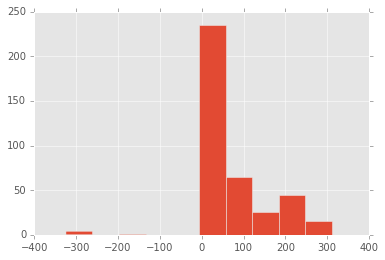

In [198]:
df['O3_avg'].hist()

In [8]:
#### import MDE data 
#### note that this is not callibrated!!
mde = pd.read_csv('data/HU_minutedata.csv', header = 2,
                   #nrows = 10,
                   skipfooter=10,
                   parse_dates={'datetime': ['Date', 'Time']},
                   ).drop(0)
for col in [u'O3', u'SO2t(trace)', u'RH', u'Temp_10m', u'NO2(NOx)']: 
    mde[col] = pd.to_numeric(mde[col], errors = 'coerce')
    mde[col] = mde[col].dropna()
mde.index = [pd.datetime.strptime(x, '%m/%d/%Y %I:%M %p') for x in mde['datetime'].values]
mde.head()

/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.


,datetime,O3,SO2t(trace),RH,Temp_10m,NO2(NOx)
2017-09-07 00:00:00,9/7/2017 12:00 AM,10.0,0.0,93.0,57.0,5.6
2017-09-07 00:01:00,9/7/2017 12:01 AM,12.0,0.0,93.0,57.0,5.7
2017-09-07 00:02:00,9/7/2017 12:02 AM,13.0,0.0,93.0,57.0,5.8
2017-09-07 00:03:00,9/7/2017 12:03 AM,11.0,0.0,93.0,57.0,5.9
2017-09-07 00:04:00,9/7/2017 12:04 AM,10.0,0.0,93.0,57.0,5.9


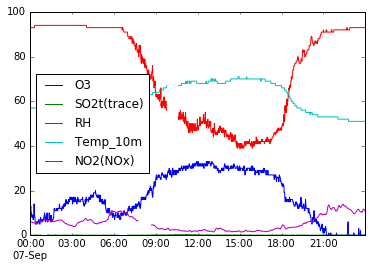

In [9]:
mde['2017-09-07'].plot()

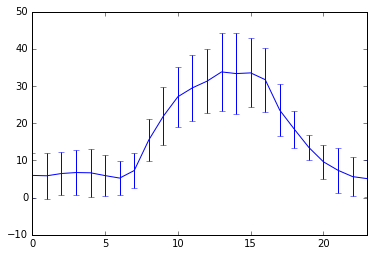

In [10]:
mde['O3'].groupby(mde.index.hour).mean().plot(yerr = mde['O3'].groupby(mde.index.hour).std() )

In [814]:
mde['O3'].argmax()

Timestamp('2017-09-16 15:20:00')

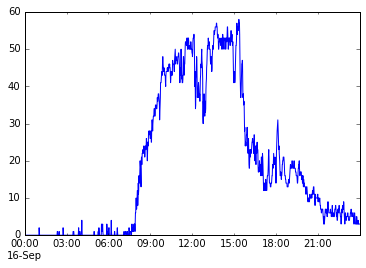

In [11]:
mde['O3'].loc['2017-09-16'].plot()

In [18]:
mde['O3'].resample('15Min').mean()['2017-09-16'].shape

(96,)

In [34]:
o3df

,10,11,12,13,14
2017-09-07 13:45:00,0.0,0.0,1205.0,NaN,NaN
2017-09-07 14:00:00,0.0,0.0,1114.0,NaN,NaN
2017-09-07 14:15:00,0.0,0.0,1065.0,0.0,NaN
2017-09-07 14:30:00,0.0,0.0,1365.0,0.0,269.0
2017-09-07 14:45:00,0.0,0.0,1542.0,0.0,358.0


In [43]:
col

10

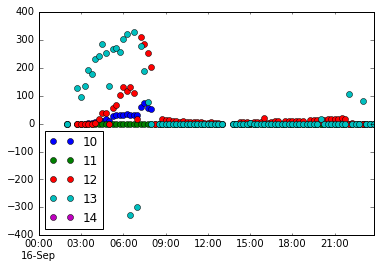

In [137]:
o3df['2017-09-16'].plot(style = 'o')

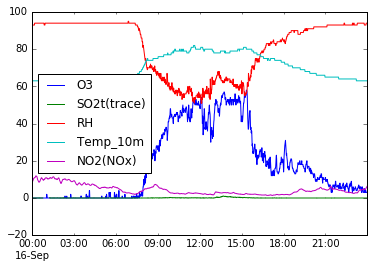

In [47]:
mde['2017-09-16'].plot()

skipping 14


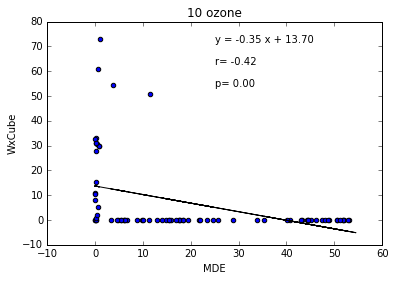

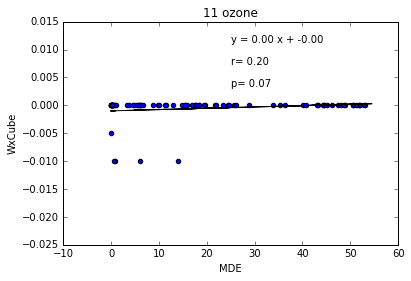

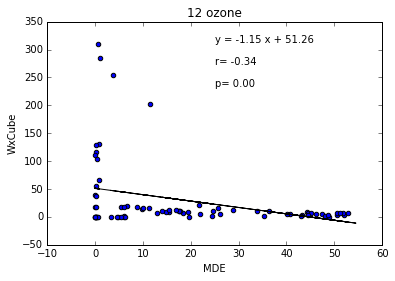

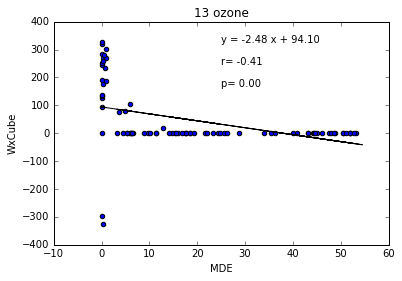

In [57]:
for col in o3df.columns: 
    try:
        plt.figure()
        easy_scatter(mde['O3'].resample('15Min').mean()['2017-09-16'], 
                     o3df['2017-09-16'][col], 
                     '%s ozone'%col, 'MDE', 'WxCube')
    except TypeError: 
        print('skipping %s'%col)

skipping 14


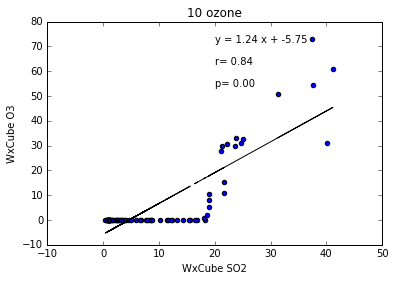

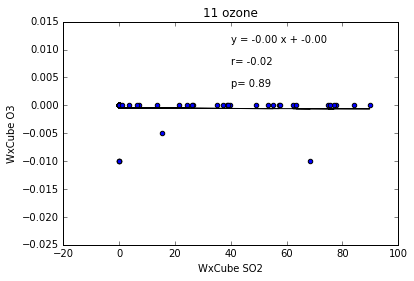

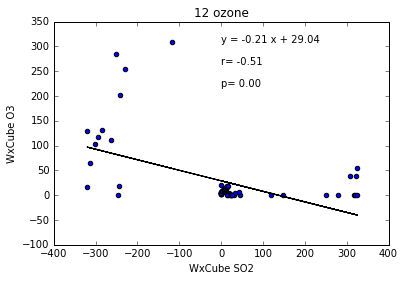

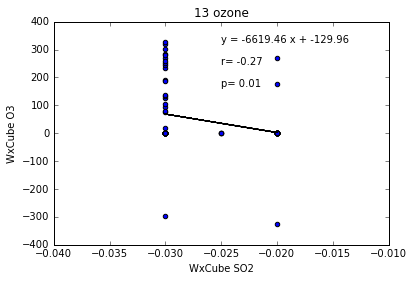

In [61]:
for col in o3df.columns: 
    try:
        plt.figure()
        easy_scatter(so2df['2017-09-16'][col], 
                     o3df['2017-09-16'][col], 
                     '%s ozone'%col, 'WxCube SO2', 'WxCube O3')
    except TypeError: 
        print('skipping %s'%col)

skipping 14


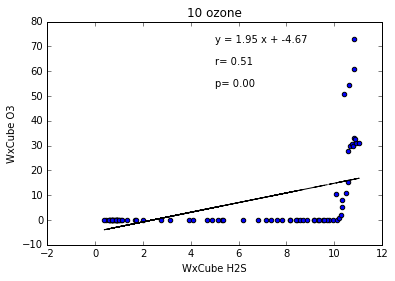

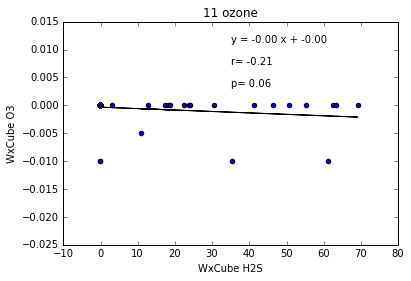

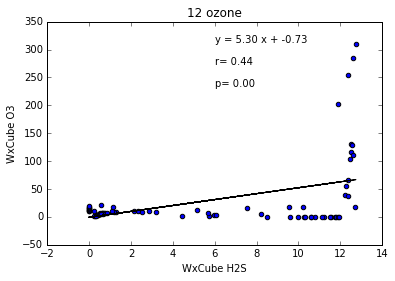

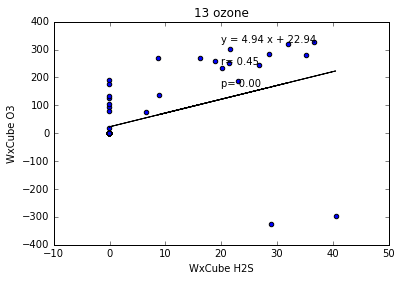

In [62]:
for col in o3df.columns: 
    try:
        plt.figure()
        easy_scatter(h2sdf['2017-09-16'][col], 
                     o3df['2017-09-16'][col], 
                     '%s ozone'%col, 'WxCube H2S', 'WxCube O3')
    except TypeError: 
        print('skipping %s'%col)

skipping 14


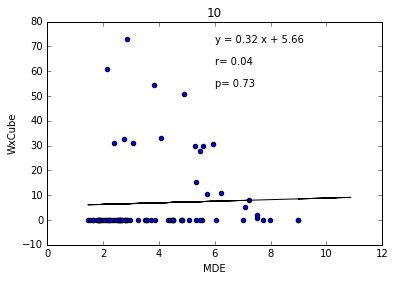

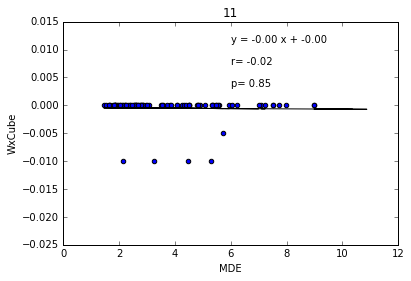

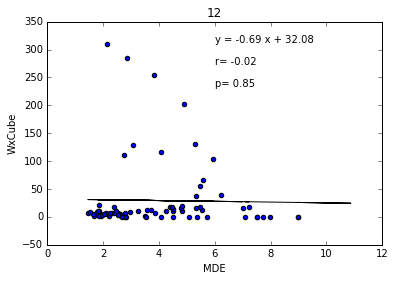

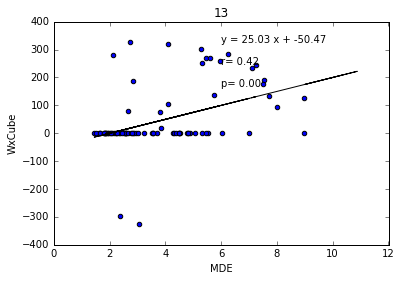

In [58]:
for col in o3df.columns: 
    try:
        plt.figure()
        easy_scatter(mde['NO2(NOx)'].resample('15Min').mean()['2017-09-16'], o3df['2017-09-16'][col], col, 'MDE', 'WxCube')
    except TypeError: 
        print('skipping %s'%col)

In [30]:
mde.head()

,datetime,O3,SO2t(trace),RH,Temp_10m,NO2(NOx)
2017-09-07 00:00:00,9/7/2017 12:00 AM,10.0,0.0,93.0,57.0,5.6
2017-09-07 00:01:00,9/7/2017 12:01 AM,12.0,0.0,93.0,57.0,5.7
2017-09-07 00:02:00,9/7/2017 12:02 AM,13.0,0.0,93.0,57.0,5.8
2017-09-07 00:03:00,9/7/2017 12:03 AM,11.0,0.0,93.0,57.0,5.9
2017-09-07 00:04:00,9/7/2017 12:04 AM,10.0,0.0,93.0,57.0,5.9


In [63]:
mde.columns

Index([u'datetime', u'O3', u'SO2t(trace)', u'RH', u'Temp_10m', u'NO2(NOx)'], dtype='object')

In [98]:
col = 10
regdf = pd.DataFrame()
regdf['o3'] = o3df[col]['2017-09-16']
regdf['no2'] = no2df[col]['2017-09-16']
regdf['so2'] = so2df[col]['2017-09-16']
regdf['h2s'] = h2sdf[col]['2017-09-16']
regdf['tru_o3'] = mde['O3']['2017-09-16']
regdf['rh'] = mde['RH']['2017-09-16']
deltaRH = (mde['RH']['2017-09-16'].iloc[1:].values - mde['RH']['2017-09-16'].iloc[:-1].values)
regdf['drh'] = pd.Series(deltaRH, index = mde['2017-09-16'].iloc[:-1].index)


In [120]:
# try a regression 
import statsmodels.formula.api as sm

result = sm.ols(formula="o3 ~ tru_o3 + no2 + so2 + h2s", data=regdf).fit()
print(result.params)
print(result.summary())

Intercept    2.408149
tru_o3      -0.056278
no2          0.007743
so2          1.928443
h2s         -2.362648
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                     o3   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     80.08
Date:                Sun, 24 Sep 2017   Prob (F-statistic):           6.17e-26
Time:                        21:35:42   Log-Likelihood:                -259.33
No. Observations:                  78   AIC:                             528.7
Df Residuals:                      73   BIC:                             540.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------

In [117]:
result.params

Intercept    2.375660
tru_o3      -0.054881
no2          0.007713
so2          1.929504
h2s         -2.361920
drh          0.064664
dtype: float64

(0.34268619416725538, 0.45983017081612804, 2.2823223747315368e-05)

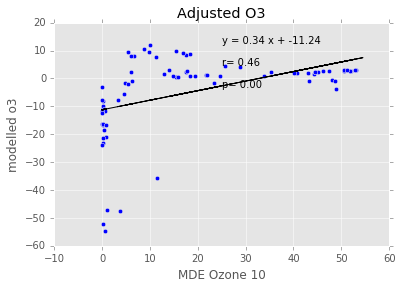

In [20]:
mod =  result.params['tru_o3']*mde['O3']['2017-09-16'] + result.params['so2']*so2df[col]['2017-09-16']+  result.params['h2s']*h2sdf[col]['2017-09-16']+  result.params['no2']*no2df[col]['2017-09-16'] 
easy_scatter(mde['O3']['2017-09-16'].resample('15Min').mean(), -1* mod.resample('15Min').mean(), 'Adjusted O3', 'MDE Ozone %s'%col, 'modelled o3')

(0.78872624825174853, 0.81723437587210002, 7.1554702843139498e-20)

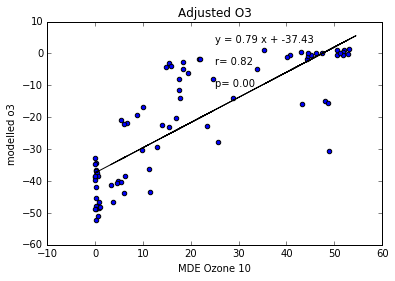

In [141]:
mod =  result.params['tru_o3']*mde['O3']['2017-09-16'] + result.params['so2']*so2df[col]['2017-09-16']+  result.params['h2s']*h2sdf[col]['2017-09-16']+  result.params['no2']*no2df[col]['2017-09-16'] 
easy_scatter(mde['O3']['2017-09-16'].resample('15Min').mean(), -1* mod.resample('15Min').mean(), 'Adjusted O3', 'MDE Ozone %s'%col, 'modelled o3')

(0.77980315524734078, 0.83476348056923855, 2.1888881232847646e-21)

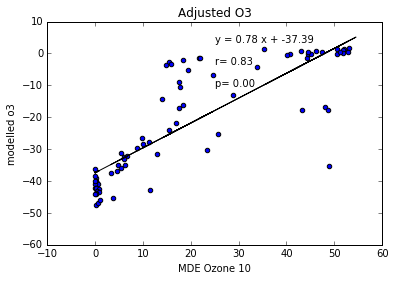

In [142]:
mod =  result.params['tru_o3']*mde['O3']['2017-09-16'] + result.params['so2']*so2df[col]['2017-09-16']+  result.params['h2s']*h2sdf[col]['2017-09-16']#+  result.params['no2']*no2df[col]['2017-09-16'] 
easy_scatter(mde['O3']['2017-09-16'].resample('15Min').mean(), -1* mod.resample('15Min').mean(), 'Adjusted O3', 'MDE Ozone %s'%col, 'modelled o3')

In [167]:
plt.rcParams.update({'font.size': 20})
plt.style.use('ggplot')

(1.0304505349645412, 0.66624301002987196, 8.5344186177689173e-141)

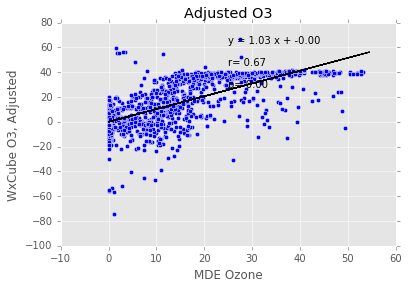

In [168]:
#mod =  result.params['tru_o3']*mde['O3']+ 
mod = result.params['so2']*so2df[col] + result.params['h2s']*h2sdf[col]+  result.params['no2']*no2df[col]#['2017-09-16'] 
x = mde['O3'].resample('15Min').mean()
y =  -1* mod.resample('15Min').mean()

easy_scatter(x, y[x.index]+ 42.40, 'Adjusted O3', 'MDE Ozone', 'WxCube O3, Adjusted')

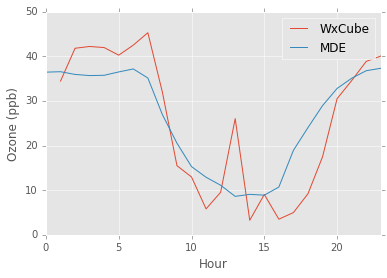

In [177]:
mod.groupby(mod.index.hour).mean().plot(label = 'WxCube')
(-1*mde['O3']+ 42.4).groupby(mde.index.hour).mean().plot(label = 'MDE')
plt.legend()
plt.xlabel('Hour')
plt.ylabel('Ozone (ppb)'

In [116]:
m_o3 = float(meta.loc[col]['qr_ozone'][28:])
m_o3

-13.64

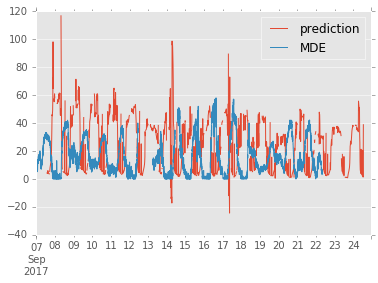

In [219]:
mod.resample('15Min').mean().plot(label = 'prediction')
mde['O3'].plot(label = 'MDE')
plt.legend()

In [134]:
# try modelling averaging all of the sensors
regdf = pd.DataFrame()
regdf['o3'] = o3df['2017-09-16'].mean(axis = 1)
regdf['no2'] = no2df['2017-09-16'].mean(axis = 1)
regdf['so2'] = so2df['2017-09-16'].mean(axis = 1)
regdf['h2s'] = h2sdf['2017-09-16'].mean(axis = 1)
regdf['tru_o3'] = mde['O3']['2017-09-16']
regdf['rh'] = mde['RH']['2017-09-16']
deltaRH = (mde['RH']['2017-09-16'].iloc[1:].values - mde['RH']['2017-09-16'].iloc[:-1].values)
regdf['drh'] = pd.Series(deltaRH, index = mde['2017-09-16'].iloc[:-1].index)

result = sm.ols(formula="o3 ~ tru_o3 + no2 + so2 + h2s", data=regdf).fit()
print(result.params)
print(result.summary())

Intercept   -0.558408
tru_o3      -0.070897
no2          0.036034
so2          0.187409
h2s          3.620994
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                     o3   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     19.62
Date:                Sun, 24 Sep 2017   Prob (F-statistic):           3.04e-11
Time:                        21:44:07   Log-Likelihood:                -398.45
No. Observations:                  84   AIC:                             806.9
Df Residuals:                      79   BIC:                             819.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------

(0.78872624825174831, 0.81723437587210002, 7.1554702843139498e-20)

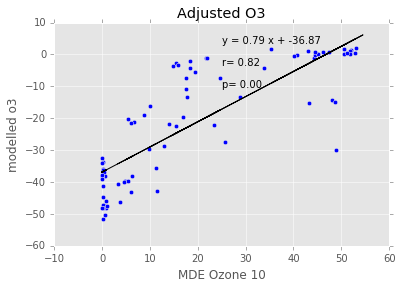

In [180]:
mod = result.params[0] + result.params['tru_o3']*mde['O3']['2017-09-16'] + result.params['so2']*so2df[col]['2017-09-16']+  result.params['h2s']*h2sdf[col]['2017-09-16']+  result.params['no2']*no2df[col]['2017-09-16'] 
easy_scatter(mde['O3']['2017-09-16'].resample('15Min').mean(), -1*mod.resample('15Min').mean(), 'Adjusted O3', 'MDE Ozone %s'%col, 'modelled o3')

(1.0304505349645412, 0.66624301002987196, 8.5344186177689173e-141)

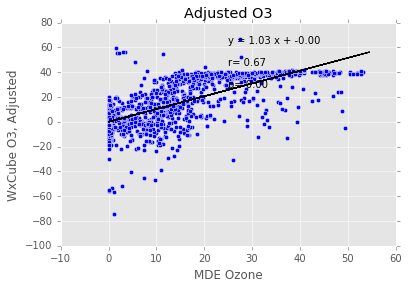

In [182]:
mod = result.params['so2']*so2df[col] + result.params['h2s']*h2sdf[col]+  result.params['no2']*no2df[col]#['2017-09-16'] 
x = mde['O3'].resample('15Min').mean()
y = -1* mod.resample('15Min').mean()

easy_scatter(x, y[x.index]+ 42.40, 'Adjusted O3', 'MDE Ozone', 'WxCube O3, Adjusted')

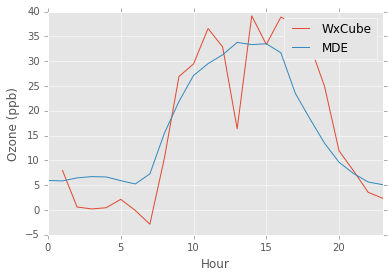

In [187]:
(-1*mod +42.4).groupby(mod.index.hour).mean().plot(label = 'WxCube')
mde['O3'].groupby(mde.index.hour).mean().plot(label = 'MDE')
plt.legend()
plt.xlabel('Hour')
plt.ylabel('Ozone (ppb)')

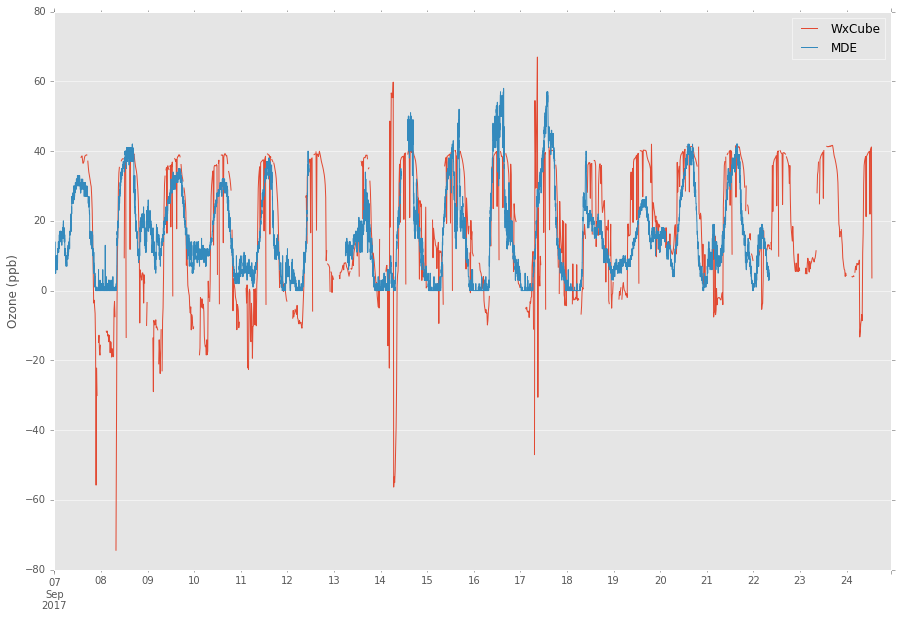

In [195]:
(-1*mod +42.4).plot(label = 'WxCube', figsize = [15,10])
mde['O3'].plot(label = 'MDE')
plt.legend()
plt.ylabel('Ozone (ppb)')

In [46]:
# do no2 sensors 
# averaging all of the sensors
regdf = pd.DataFrame()
regdf['o3'] = o3df['2017-09-16'].mean(axis = 1)
regdf['no2'] = no2df['2017-09-16'].mean(axis = 1)
regdf['so2'] = so2df['2017-09-16'].mean(axis = 1)
regdf['h2s'] = h2sdf['2017-09-16'].mean(axis = 1)
regdf['tru_o3'] = mde['O3']['2017-09-16']
regdf['tru_no2'] = mde['NO2(NOx)']['2017-09-16']
regdf['rh'] = mde['RH']['2017-09-16']
deltaRH = (mde['RH']['2017-09-16'].iloc[1:].values - mde['RH']['2017-09-16'].iloc[:-1].values)
regdf['drh'] = pd.Series(deltaRH, index = mde['2017-09-16'].iloc[:-1].index)

result = sm.ols(formula="no2 ~ tru_no2 + o3 + so2 + h2s", data=regdf).fit()
print(result.params)
print(result.summary())

Intercept    20.835668
tru_no2      -8.129923
o3            0.109793
so2          -0.289046
h2s          -2.584159
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     12.34
Date:                Sun, 24 Sep 2017   Prob (F-statistic):           7.64e-08
Time:                        23:24:26   Log-Likelihood:                -417.95
No. Observations:                  84   AIC:                             845.9
Df Residuals:                      79   BIC:                             858.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-

In [47]:
result.params

Intercept    20.835668
tru_no2      -8.129923
o3            0.109793
so2          -0.289046
h2s          -2.584159
dtype: float64

In [ ]:
mod = result.params[0] + result.params['tru_no2']*mde['NO2(NOx)']['2017-09-16'] + result.params['so2']*so2df['2017-09-16']+  result.params['h2s']*h2sdf['2017-09-16']#+  result.params['o3df']*o3df['2017-09-16'] 
easy_scatter(mde['NO2(NOx)']['2017-09-16'].resample('15Min').mean(), 
             mod.resample('15Min').mean(), 'Adjusted NO2', 'MDE NO2 %s'%col, 'modelled NO2')

In [92]:
# read in 
m_o3 = float(meta.loc[sel_id]['qr_ozone'].dropna().iloc[0][28:])
m_no2 = float(meta.loc[sel_id]['qr_no2'].dropna().iloc[0][28:])
m_h2s = float(meta.loc[sel_id]['qr_h2s'].dropna().iloc[0][28:])
m_so2= float(meta.loc[sel_id]['qr_so2'].dropna().iloc[0][28:])

In [96]:
response = table.query(
            KeyConditionExpression=Key('id').eq('21') & Key('timest').gt(20000101000015)
        )

In [97]:
response.keys()

[u'Count', u'Items', u'ScannedCount', 'ResponseMetadata']

In [98]:
len(response['Items'])

354

In [239]:
df = pd.DataFrame(response['Items'])
## convert post timestamp to datetime
df['timest'] = [pd.to_datetime(str(date)[:-4], format = '%Y%m%d%H%M') for date in df['timest']]
# read in batteryAV to get the time
df[['something', 'HourMinute', 'MonthDay', 'AV', 'drop'] ] = df['battAV'].str.split(',').apply(pd.Series)

# set up time index 
date_index = []
for date in df[['MonthDay', 'HourMinute']].values : 
    try: 
        if date[0] == '32767' : 
            date_index.append(np.nan)
        elif date[0] == '0' : 
            date_index.append(np.nan)
        else:
            date_index.append(pd.to_datetime('2017' +date[0]+date[1], format = '%Y%m%d%H%M'))
    except ValueError:  
        date_index.append(np.nan)

df.index = date_index

In [242]:
df

,H2S_avg,H2S_std,NO2_avg,NO2_std,O3_avg,O3_std,SO2_avg,SO2_std,battAV,hum1,...,id,temp1,temp2,temp3,timest,something,HourMinute,MonthDay,AV,drop
NaT,32767,32767,32767,32767,32767,32767,32767,32767,"32767,32767,32767,32767p",32767,...,21,32767,32767,32767,2000-01-01 00:00:00,32767,32767,32767,32767p,NaN
NaT,0,0,0,0,0,0,0,0,"0,0,0,0,",0,...,21,0,0,0,2000-01-01 00:00:00,0,0,0,0,
NaT,32767,32767,32767,32767,32767,32767,32767,32767,"32767,32767,32767,32767p",32767,...,21,32767,32767,32767,2000-01-01 00:00:00,32767,32767,32767,32767p,NaN
NaT,0,0,0,0,0,0,0,0,"0,0,0,0,",0,...,21,0,0,0,2017-09-16 02:01:00,0,0,0,0,
NaT,32767,32767,32767,32767,32767,32767,32767,32767,"32767,32767,32767,32767p",32767,...,21,32767,32767,32767,2017-09-17 01:07:00,32767,32767,32767,32767p,NaN
NaT,32767,32767,32767,32767,32767,32767,32767,32767,"32767,32767,32767,32767p",32767,...,21,32767,32767,32767,2017-09-17 01:07:00,32767,32767,32767,32767p,NaN
NaT,32767,32767,32767,32767,32767,32767,32767,32767,"32767,32767,32767,32767p",32767,...,21,32767,32767,32767,2017-09-17 01:07:00,32767,32767,32767,32767p,NaN
NaT,32767,32767,32767,32767,32767,32767,32767,32767,"32767,32767,32767,32767p",32767,...,21,32767,32767,32767,2017-09-17 01:07:00,32767,32767,32767,32767p,NaN
NaT,32767,32767,32767,32767,32767,32767,32767,32767,"32767,32767,32767,32767p",32767,...,21,32767,32767,32767,2017-09-17 01:07:00,32767,32767,32767,32767p,NaN
NaT,32767,32767,32767,32767,32767,32767,32767,32767,"32767,32767,32767,32767p",32767,...,21,32767,32767,32767,2017-09-17 01:07:00,32767,32767,32767,32767p,NaN


(736587.0, 736590.0)

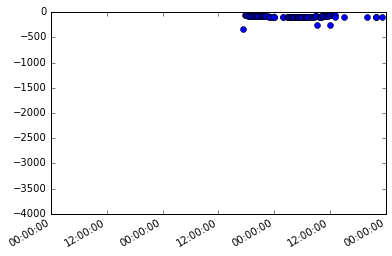

In [248]:
df['O3_avg'].astype(float).multiply(0.01 *m_o3).plot(style='o')
plt.xlim(['2017-09-15', '2017-09-18'])

(736587.0, 736590.0)

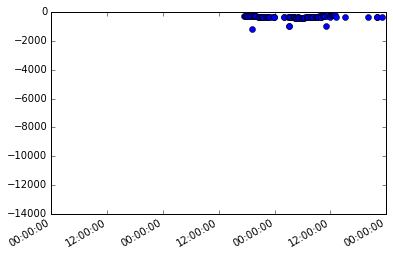

In [249]:
df['NO2_avg'].astype(float).multiply(0.01 *m_no2).plot(style='o')
plt.xlim(['2017-09-15', '2017-09-18'])

(736587.0, 736590.0)

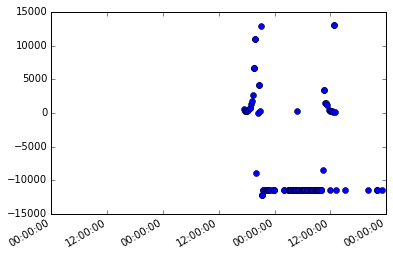

In [251]:
df['SO2_avg'].astype(float).multiply(0.01 *m_so2).plot(style='o')
plt.xlim(['2017-09-15', '2017-09-18'])

(736587.0, 736590.0)

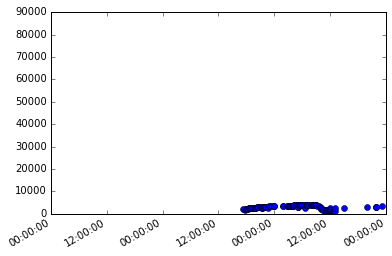

In [250]:
df['H2S_avg'].astype(float).multiply(0.01 *m_h2s).plot(style='o')
plt.xlim(['2017-09-15', '2017-09-18'])

In [264]:
aq = pd.read_csv('/Users/annascott2/Downloads/daily_24_033_9991_2017.csv')
aq.index = pd.DatetimeIndex(aq['Date (Local)'])

In [265]:
aq.index

DatetimeIndex(['2017-01-01', '2017-01-01', '2017-01-01', '2017-01-01',
               '2017-01-01', '2017-01-01', '2017-01-01', '2017-01-01',
               '2017-01-02', '2017-01-02',
               ...
               '2017-06-26', '2017-06-26', '2017-06-27', '2017-06-27',
               '2017-06-28', '2017-06-28', '2017-06-29', '2017-06-29',
               '2017-06-30', '2017-06-30'],
              dtype='datetime64[ns]', length=968, freq=None)

In [262]:
aq.head()

,State Code,County Code,Site Number,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Duration Description,...,AQI,Daily Criteria Indicator,Tribe Name,State Name,County Name,City Name,Local Site Name,Address,MSA or CBSA Name,Data Source
Date (Local),,,,,,,,,,,,,,,,,,,,,
2017-01-01,24,33,9991,42601,1,39.0284,-76.8171,WGS84,Nitric oxide (NO),1 HOUR,...,.,Y,NaN,Maryland,Prince George's,Not in a City,Beltsville,"Powder Mill Rd, Laurel, MD 20708","Washington-Arlington-Alexandria, DC-VA-MD-WV",AQS Data Mart
2017-01-01,24,33,9991,42401,1,39.0284,-76.8171,WGS84,Sulfur dioxide,1 HOUR,...,0,Y,NaN,Maryland,Prince George's,Not in a City,Beltsville,"Powder Mill Rd, Laurel, MD 20708","Washington-Arlington-Alexandria, DC-VA-MD-WV",AQS Data Mart
2017-01-01,24,33,9991,42401,1,39.0284,-76.8171,WGS84,Sulfur dioxide,24-HR BLK AVG,...,.,Y,NaN,Maryland,Prince George's,Not in a City,Beltsville,"Powder Mill Rd, Laurel, MD 20708","Washington-Arlington-Alexandria, DC-VA-MD-WV",AQS Data Mart
2017-01-01,24,33,9991,42401,2,39.0284,-76.8171,WGS84,Sulfur dioxide,5 MINUTE,...,.,Y,NaN,Maryland,Prince George's,Not in a City,Beltsville,"Powder Mill Rd, Laurel, MD 20708","Washington-Arlington-Alexandria, DC-VA-MD-WV",AQS Data Mart
2017-01-01,24,33,9991,42600,1,39.0284,-76.8171,WGS84,Reactive oxides of nitrogen (NOy),1 HOUR,...,.,Y,NaN,Maryland,Prince George's,Not in a City,Beltsville,"Powder Mill Rd, Laurel, MD 20708","Washington-Arlington-Alexandria, DC-VA-MD-WV",AQS Data Mart


In [257]:
aq.columns

Index([u'State Code', u'County Code', u'Site Number', u'Parameter Code',
       u'POC', u'Latitude', u'Longitude', u'Datum', u'Parameter Name',
       u'Duration Description', u'Pollutant Standard', u'Date (Local)',
       u'Year', u'Day In Year (Local)', u'Units of Measure',
       u'Exceptional Data Type', u'Nonreg Observation Count',
       u'Observation Count', u'Observation Percent', u'Nonreg Arithmetic Mean',
       u'Arithmetic Mean', u'Nonreg First Maximum Value',
       u'First Maximum Value', u'First Maximum Hour', u'AQI',
       u'Daily Criteria Indicator', u'Tribe Name', u'State Name',
       u'County Name', u'City Name', u'Local Site Name', u'Address',
       u'MSA or CBSA Name', u'Data Source'],
      dtype='object')

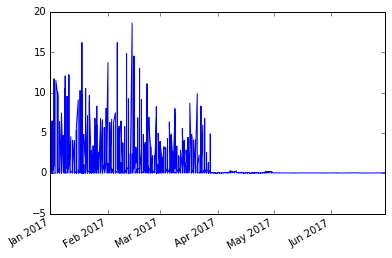

In [266]:
aq['Arithmetic Mean'].plot()